In [226]:
import pandas as pd
import stanza
import string
import time
import re
import nltk
import numpy as np

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim import corpora, models
from gensim.models import  Word2Vec
import gensim
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from matplotlib import cm 
from gensim.utils import simple_preprocess
import pyLDAvis
from pyLDAvis import gensim_models
from gensim.models.ldamodel import LdaModel
import logging
from gensim.test.utils import datapath

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    i=0
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

def top_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids if row[i]>0]
    df = pd.DataFrame(top_feats)
    if len(top_feats) > 0:
        df.columns = ['feature', 'score']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_feats(row, features, top_n)

def get_law(xpo2, dat, nbdoc):

    count = 0
    tmp = {}
    
    for i in range(len(xpo2)):
        for y in range(len(xpo2.iloc[i])):
            if xpo2.iloc[i,y] is np.nan:
                break
            else:
                tmp[count] = i
                count +=1
#    print(tmp)
    
    return(tmp[nbdoc])

def initialisation():
    
    ### IMPORTS

        # CF AU DESSUS
    
    ### STOPWORDS
    
    with open("./stopwords/Stop-words-french.txt", "r", encoding='utf8') as f:
        stopW1 = [line.rstrip("\n") for line in f.readlines()]
    with open("./stopwords/stopword.txt", "r", encoding='utf8') as f:
        stopW2 = [line.rstrip("\n") for line in f.readlines()]
    with open("./stopwords/stopwords_topics.txt", "r", encoding='utf8') as f:
        stopW3 = [line.rstrip("\n") for line in f.readlines()]
    stopW = stopW1 + stopW2 + stopW3 #+ stopwords.words("french")
    stopW.extend(string.punctuation)
    stopW.extend(['’', '«', '»', '…', '—','».', '»,', '---', '.—', '…—', 'ans', 'an'])
    
    ### IMPORT TABLEAU
    
    xpo2 = pd.read_excel("./Exports/sentences_lemma.xlsx", index_col=0)

    i, j = xpo2.shape
    print(i, j)

    for x in range(i):
        for y in range(j):
            if pd.isna(xpo2[y][x]) == True:
                continue
            else:
                sent = xpo2[y][x]
                sent = ''.join(sent)

                sent = re.sub('\'', '', sent)
                sent = re.sub('\]', '', sent)
                sent = re.sub('\[', '', sent)

                sent = sent.split(', ')
                xpo2[y][x] = sent

    ### NETTOYAGE DONNEES
    
    dat = [x for i in xpo2.index for x in xpo2.iloc[i] if x is not np.nan]
    for i in range(len(dat)):
#        print(dat[i])
        sent = re.sub(r'[^A-Za-zÀ-ÿ-’\' ]+', '', ' '.join(dat[i]))
        sent = nltk.word_tokenize(sent)
        stop_doc = [word for word in sent if word not in stopW]
        dat[i] = stop_doc
    
    ### PREPRA LDA
    
    data = dat

        # création du dictionnaire
    dico = corpora.Dictionary(data)

        # ce qui permet par ex. de filtrer le vocabulaire
    dico.filter_extremes(no_below=10)

        # Create Corpus
    texts = data

        # matrice Term Document Frequency
    corpus = [dico.doc2bow(text) for text in texts]
    
    ### LDA
    
    ntopics = 20
    
    generate_lda = False  # FALSE POUR LOADER LE FICHIER DE NOS THEMATIQUES

    if generate_lda:
        print("generate new LDA model")
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
        ldamodel = LdaModel(corpus, num_topics=ntopics, id2word = dico,
                                           passes=2, random_state=100, per_word_topics=True)
        print(ldamodel)

    temp_file = datapath("model20_lemma2") #"model20_lemma"

    if generate_lda:
        ldamodel.save(temp_file)
    else:
        ldamodel = LdaModel.load(temp_file) 
        print('loaded')
        
        
    ### TABLEAU DES TOPICS
    
    ldc = ldamodel[corpus]

        # ON APPELLE LA FONCTION format_topics_sentences() APPELEE PLUS HAUT
    df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data)

    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    
        # SUPRRESION DES RANGS VIDES

    df_dominant_topic_novoid = df_dominant_topic.loc[df_dominant_topic.Topic_Perc_Contrib > 0.06]
    
    ### RECUPERER LES LOIS ASSOCIES AUX TOPICS
    
    df3 = pd.read_excel("./Exports/final_export.xlsx")
    df3 = df3[df3["preprocessed_xpo"].isna() == False]
    df3.reset_index(inplace=True, drop=True)
    df3 = df3.iloc[:,1:]
    for i in range(len(df3)):
        df3.preprocessed_xpo[i] = re.sub("'", "", str(df3.preprocessed_xpo[i]))

        # ON CREE LA VARIABLE TMP
    
    count = 0
    tmp = {}
    
    for i in range(len(xpo2)):
        for y in range(len(xpo2.iloc[i])):
            if xpo2.iloc[i,y] is np.nan:
                break
            else:
                tmp[count] = i
                count +=1
    
        # CREATION DU DATAFRAME POUR REPRESENTER LES LOIS/TOPICS
    
    xpo3 = xpo2
    tempo = [[] for i in range(len(df3))]

    for i, sent in enumerate(df_dominant_topic_novoid.sort_values("Topic_Perc_Contrib", ascending=False).Document_No):
        temporary = df_dominant_topic_novoid.loc[sent].Dominant_Topic
        tempo[tmp[sent]].append(temporary)
    
    test = pd.DataFrame(tempo)
    #test.dropna(thresh=len(tempo)/2, axis=1, inplace=True)
    df3['topics'] = [None for i in range(len(xpo3))]

    test2 = []

    for i in range(len(test)):
        test2.append(test.loc[i].value_counts().index[0])
    #    print(i, test.loc[i].value_counts().index[0])
    df3.topics = test2
    
    ### TABLEAU TOPICS PAR PHRASE
    
    senttop = df_dominant_topic_novoid
    senttop['year'] = ['' for i in range(len(senttop))]
    senttop['legislature'] = ['' for i in range(len(senttop))]

    for line in df_dominant_topic_novoid.index:
        senttop['year'].loc[line] = df3.year.loc[tmp[line]]
        senttop['legislature'].loc[line] = df3.legislature.loc[tmp[line]]
        
    ### COLLOCATION
    
        #TABLEAU POUR LES COLLOCATION
    
    senttop2 = senttop

    for idx in senttop2.index:
        text = str(senttop2.Text.loc[idx])
        text = re.sub('\[', '', text)
        text = re.sub('\]', '', text)
        text = re.sub('\'', '', text)
        senttop2.Text.loc[idx] = text

        # COLLOCATION SUR L'ENSEMBLE DU TABLEAU : LES PLUS FORTES COLLOC PAR AN
        
    law = {}

    for year in senttop2.year.sort_values().unique():
        
        law_x = senttop2.Text.loc[senttop2.year == year].values
        topics_x = senttop2.Dominant_Topic.loc[senttop2.year == year].values

        law[year] = law_x
        
        # COLLOCATION SUR L'ENSEMBLE DES PHRASES ET TOPICS
        
    law_t = {}

    for year in senttop2.year.sort_values().unique():
        law_t[year] = senttop2[['Dominant_Topic', 'year', 'Text']].loc[senttop2.year == year]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:84: DeprecationWarning: invalid escape sequence \]
<>:85: DeprecationWarning: invalid escape sequence \[
<>:212: DeprecationWarning: invalid escape sequence \[
<>:213: DeprecationWarning: invalid escape sequence \]
<>:84: DeprecationWarning: invalid escape sequence \]
<>:85: DeprecationWarning: invalid escape sequence \[
<>:212: DeprecationWarning: invalid escape sequence \[
<>:213: DeprecationWarning: invalid escape sequence \]
<ipython-input-63-c80c909c44bb>:84: DeprecationWarning: invalid escape sequence \]
  sent = re.sub('\]', '', sent)
<ipython-input-63-c80c909c44bb>:85: DeprecationWarning: invalid escape sequence \[
  sent =

In [ ]:
# PEUT METTRE UN PEU DE TEMPS

initialisation()

In [28]:
#CREER LE TABLEAU DE TRAVAIL : 1. supprime les lois sans xpo, reset l'index, lemmatise, et exporte

# /!\ Ne pas relancer la procédure, le tableau a été exporté et ré-importé/re-traiter après

df = pd.read_excel("./Exports/export_excel.xlsx") 

df2 = pd.DataFrame()
df2["xpo"] = ["" for i in range(len(df))]

for i in range(len(df)):
    if pd.isna(df["Exposé des motifs"][i]) == False:
        df2["xpo"][i] = df["Exposé des motifs"][i]
#        print("it")
    elif pd.isna(df["Exposé des motifs"][i]) == True and pd.isna(df["Communiqué de presse"][i]) == False:
        df2["xpo"][i] = df["Communiqué de presse"][i]

df2 = df2.loc[df2.xpo != ""]
df2.reset_index(inplace=True, drop=True)
#df2 = df2.iloc[:,1]
df2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,xpo
0,
1,La France a signé le 18 décembre 2008 à Paris...
2,"NOR : INTX1232040L Depuis 1986, la France s'e..."
3,
4,Le présent projet de loi poursuit deux object...
...,...
740,
741,Le ministre des finances et des comptes public...
742,ExposÉ des motifs Le projet de loi qui vous e...
743,Représentant de la Nation et garant du foncti...


In [11]:
nlp = stanza.Pipeline('fr')
xpo = []
for i in range(len(df2)):
    xpo.append(df2.xpo[i])

for i in range(len(xpo)):
    start = time.time()
    doc = nlp(xpo[i])
    sent = []
    for j, sentence in enumerate(doc.sentences):
        sent.append((j, [word.lemma for word in sentence.words if word.lemma.lower() not in stopW and word.lemma.lower() != "l'"]))
        xpo[i] = dict(sent)
    end = time.time()
    print("Temps {:.5}s".format(end-start), len(xpo)-i)

Temps 25.079s 472
Temps 21.08s 471
Temps 56.038s 470
Temps 71.583s 469
Temps 8.975s 468
Temps 43.368s 467
Temps 56.897s 466
Temps 15.0s 465
Temps 62.143s 464
Temps 24.888s 463
Temps 24.583s 462
Temps 9.9331s 461
Temps 59.174s 460
Temps 64.246s 459
Temps 59.959s 458
Temps 61.056s 457
Temps 9.8755s 456
Temps 10.873s 455
Temps 58.931s 454
Temps 6.7218s 453
Temps 15.493s 452
Temps 5.0733s 451
Temps 30.327s 450
Temps 11.925s 449
Temps 26.152s 448
Temps 53.409s 447
Temps 69.787s 446
Temps 65.696s 445
Temps 61.906s 444
Temps 27.841s 443
Temps 63.467s 442
Temps 56.39s 441
Temps 19.953s 440
Temps 3.7829s 439
Temps 31.753s 438
Temps 10.035s 437
Temps 6.2731s 436
Temps 56.794s 435
Temps 20.081s 434
Temps 11.727s 433
Temps 61.114s 432
Temps 38.997s 431
Temps 13.836s 430
Temps 3.4279s 429
Temps 143.33s 428
Temps 30.83s 427
Temps 74.496s 426
Temps 7.4761s 425
Temps 2.8409s 424
Temps 10.579s 423
Temps 6.4097s 422
Temps 68.286s 421
Temps 24.982s 420
Temps 45.602s 419
Temps 39.8s 418
Temps 47.709s 417


Temps 3.5736s 8
Temps 7.6751s 7
Temps 5.3294s 6
Temps 8.7409s 5
Temps 4.4358s 4
Temps 22.288s 3
Temps 13.324s 2
Temps 17.52s 1


In [15]:
#dataf = pd.DataFrame(xpo)
#dataf.to_excel("./Exports/sentences_lemma.xlsx")

In [5]:
# IMPORTATION DU TABLEAU DE TRAVAIL (QUI A ETE CREE AU DESSUS)

xpo2 = pd.read_excel("./Exports/sentences_lemma.xlsx", index_col=0)

i, j = xpo2.shape
print(i, j)

for x in range(i):
    for y in range(j):
        if pd.isna(xpo2[y][x]) == True:
            continue
        else:
            sent = xpo2[y][x]
            sent = ''.join(sent)

            sent = re.sub('\'', '', sent)
            sent = re.sub('\]', '', sent)
            sent = re.sub('\[', '', sent)

            sent = sent.split(', ')
            xpo2[y][x] = sent

    # TRANSFO DU TABLEAU EN LISTE DE STR
            
dat = [x for i in xpo2.index for x in xpo2.iloc[i] if x is not np.nan]
for i in range(len(dat)):
#        print(dat[i])
    sent = re.sub(r'[^A-Za-zÀ-ÿ-’\' ]+', '', ' '.join(dat[i]))
    sent = nltk.word_tokenize(sent)
    stop_doc = [word for word in sent if word not in stopW]
    dat[i] = stop_doc
    
dat[0:500]

472 209


,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,"[France, signer, 18, 2008, Paris, accord, agen...","[objet, accord, préciser, 2]","[prévoir, modalité, terrain, CSG, agence, préc...","[3, préciser, engagement, obligation, gouverne...","[France, garantir, abord, centre, national, ét...","[France, responsabilité, infrastructure, base,...","[charge, prendre, sauvegarde, sûreté, CSG, ass...","[accord, prévoir, agence, pouvoir, consulter, ...","[devoir, informer, agence, préalablement, refu...","[France, responsabilité, direct, protection, e...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[INTX1232040L, 1986, France, progressivement, ...","[efficace, devoir, permanence, adapter, évolut...","[contexte, où, menace, terroriste, demeurer, é...","[aller, police, administratif, introduire, 3, ...","[prévoir, expérimental, législateur, durée, re...","[nouveau, prorogation, souci, constant, concil...","[pénal, compléter, français, appliquer, incond...","[modification, poursuivre, efficacement, perso...","[modifier, entrée, séjour, étranger, asile, CE...","[L., 521-3, CESEDA, expulsion, étranger, majeu...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[présent, poursuivre, objectif, améliorer, par...","[I., relatif, participation, citoyen, fonction...","[participation, citoyen, fonctionnement, justi...","[assurer, décision, juridictionnel, déconnecte...","[renforcer, lien, devant, exister, population,...","[raison, lequel, présent, objectif, participat...","[fin, procéder, série, modification]","[premier, lieu, prévoir, jugement, délit, port...","[dernier, accomplir, devoir, civique]","[deuxième, lieu, prévoir, jugement, premier, r...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[activité, législatif, soutenir, conseil, unio...","[importance, réforme, agir, essentiel, consoli...","[présent, rassembler, œuvre, national, réforme]","[1er, relatif, transposition, directive, 2014,...","[directive, viser, doter, pouvoir, public, nou...","[habiliter, gouvernement, prendre, ordonnance,...","[2, relatif, transposition, directive, 2014, 4...","[directive, précité, substituer, directive, 20...","[directive, 2014, 49, UE, viser, harmoniser, n...","[fin, prévoir, plusieurs, modification, import...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[er, transposer, directive, 2003, 72, conseil,...","[statut, société, coopératif, européen, concev...","[nouveau, devoir, porter, atteindre, travaille...","[communautaire, directive, indissociable, préa...","[directive, articuler, autour, principe, évite...","[agir, principe, -après]","[imposer, règle, inconnu, conforme, système, r...","[présent, transposition, inspirer, largement, ...","[réserver, traitement, particulier, petit, soc...","[prévoir, conseil, préciser, modalité, applica...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,"[ministre, public, réforme, porte-parole, gouv...","[réduction, endettement, public, priorité]","[passer, abord, réduction, déficit, public]","[finance, 2012, confirmer, égard, caractère, i...","[déficit, public, ramener, 5,7, 2011, 4,5, 201...","[France, entamer, désendettement, dès, 2013, r...","[2012, gouvernement, choisir, retenir, hypothè...","[choix, répondre, souci, prudence, contexte, c...","[dépit, fondamental, économique, solide, Franc...","[gouvernement, constater, demande, intérieur, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,"[ministre, finance, public, secrétaire, charge...","[résultat, obtenir, 2014, montrer, effort, dem...","[déficit, public, situer, 4, PIB, continuer, r...","[nettement, inférieur, prévision, 4,4, reposer...","[déficit, structurel, éliminer, cycle, économi...","[résultat, obtenir, grâce, gestion, sérieux, d...","[dépense, dépense, exceptionnel, charge, intér...","[diminution, tel, ampleur, précédent, instaura...","[total, dépense, ensemble, administration, pub...","[progression, historiquement, bas]",...,NaN,NaN,NaN,NaN,NaN,Na

In [12]:
### DEBUT LDA

data = dat

# création du dictionnaire
dico = corpora.Dictionary(data)

# ce qui permet par ex. de filtrer le vocabulaire
dico.filter_extremes(no_below=10)

# Create Corpus
texts = data

# matrice Term Document Frequency
corpus = [dico.doc2bow(text) for text in texts]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [364]:
#ntopics = 50
ntopics = 23

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [369]:
generate_lda = False

if generate_lda:
    print("generate new LDA model")
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    ldamodel = LdaModel(corpus, num_topics=ntopics, id2word = dico,
                                           passes=2, random_state=100, per_word_topics=True)
    print(ldamodel)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [370]:
from gensim.test.utils import datapath

temp_file = datapath("model15_lemma") #"model20_lemma" "model20_lemma2" "model15_lemma2"

if generate_lda:
    ldamodel.save(temp_file)
else:
    ldamodel = LdaModel.load(temp_file) 
    print('loaded')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2022-01-14 21:15:16,765 : INFO : loading LdaModel object from /opt/anaconda3/lib/python3.8/site-packages/gensim/test/test_data/model15_lemma
2022-01-14 21:15:16,779 : INFO : loading expElogbeta from /opt/anaconda3/lib/python3.8/site-packages/gensim/test/test_data/model15_lemma.expElogbeta.npy with mmap=None
2022-01-14 21:15:16,787 : INFO : setting ignored attribute dispatcher to None
2022-01-14 21:15:16,789 : INFO : setting ignored attribute id2word to None
2022-01-14 21:15:16,791 : INFO : setting ignored attribute state to None
2022-01-14 21:15:16,799 : INFO : LdaModel lifecycle event {'fname': '/opt/anaconda3/lib/python3.8/site-pack

loaded


In [367]:
pwz = ldamodel.get_topics()

print("On peut récupérer la matrice stockant p(w/z):", pwz.shape)

On peut récupérer la matrice stockant p(w/z): (23, 3636)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [371]:
ldamodel.show_topics(num_topics=ntopics,formatted=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('conseil', 0.055645008),
   ('président', 0.03040191),
   ('assemblée', 0.021983158),
   ('organique', 0.020971196),
   ('république', 0.019764815),
   ('modalité', 0.019634161),
   ('uvre', 0.019203495),
   ('préciser', 0.01811364),
   ('membre', 0.017368399),
   ('décision', 0.017064156)]),
 (1,
  [('conséquence', 0.021923093),
   ('tirer', 0.012652769),
   ('bénéfice', 0.012163569),
   ('prioritaire', 0.01133672),
   ('commercial', 0.011046959),
   ('cour', 0.010613057),
   ('personne', 0.010427674),
   ('aide', 0.009911703),
   ('devant', 0.008823815),
   ('faire', 0.008739891)]),
 (2,
  [('peine', 0.045224827),
   ('personne', 0.041356605),
   ('lorsque', 0.018262716),
   ('pénal', 0.01653836),
   ('infraction', 0.015428254),
   ('pouvoir', 0.013166049),
   ('condamner', 0.012411331),
   ('situation', 0.009728659),
   ('enfant', 0.009168331),
   ('déchet', 0.008767115)]),
 (3,
  [('ministre', 0.031991635),
   ('public', 0.026875982),
   ('année', 0.022321992),
   ('rappor

In [223]:
tab = ldamodel.get_topics()
myword = dico.token2id['sécurité']
np.where(tab[:,myword]>0.0005)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([12]),)

In [227]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, gensim.matutils.corpus2csc(corpus), dictionary=ldamodel.id2word)
#vis
pyLDAvis.display(vis)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


19, 16, 20, 6, 3, ...

In [228]:
# CREATION DU TABLEAU df_dominant_topic A PARTIR DE LA FONCTION format_topics_sentences()

ldc = ldamodel[corpus]

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [231]:
df_dominant_topic.sort_values("Dominant_Topic", ascending=False)
df_dominant_topic_novoid = df_dominant_topic.loc[df_dominant_topic.Topic_Perc_Contrib > 0.07]
df_dominant_topic_novoid.sort_values("Topic_Perc_Contrib", ascending=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
64,64,11.0,0.9611,"européen, France, parlement, directive, union,...","[tel, principal, observation, appeler, accord,..."
20493,20493,14.0,0.9594,"pouvoir, autorité, contrôle, public, obligatio...","[porter, durée, maximal, rétention, administra..."
5150,5150,9.0,0.9594,"politique, développement, gouvernement, object...","[habiliter, gouvernement, prendre, part, rendr..."
5145,5145,9.0,0.9594,"politique, développement, gouvernement, object...","[habiliter, gouvernement, prendre, part, rendr..."
1862,1862,8.0,0.9576,"finance, public, impôt, revenu, euro, fiscal, ...","[total, déficit, milliard, euro, baisse, milli..."
...,...,...,...,...,...
14159,14159,10.0,0.1519,"vigueur, entrée, produit, transport, réseau, s...","[proposer, insérer, CESEDA, placement, surveil..."
7739,7739,9.0,0.1512,"politique, développement, gouvernement, object...","[nombre, proposer, relever, compétence, pouvoi..."
26886,26886,8.0,0.1511,"finance, public, impôt, revenu, euro, fiscal, ...","[traduire, décision, prendre, rendez, retraite..."
30299,30299,0.0,0.1508,"conseil, président, assemblée, organique, répu...","[issue, journée, riche, audition, expert, jury..."


In [171]:
# SUPPRIMER CERTAINS MOTS DU CORPUS EN FONCTION D'UN TOPIC  /!\ NE PAS EXECUTER !

tab = ldamodel.get_topics()
temp = np.where(tab[8,:]>0.009)
temp = [dico[word] for word in temp[0] if dico[word] not in ['élection', 'public', 'nouveau']]

temp2 = np.where(tab[19,:]>0.01)
temp2 = [dico[word] for word in temp2[0] if dico[word] not in ['nouveau', 'transport', 'organisation', 'convention', 'réseau', 'section', 'syndical'
                                                              , "règle", 'personne', 'service', 'public', 'obligation', 'régime']]

print(temp2)
#temp2 = [word for word, prob in ldamodel.show_topic(19) if word not in ['nouveau', 'transport', 'organisation', 'convention']]
top_stop_words = temp+temp2
#top_stop_words
with open("./stopwords/stopwords_topics.txt", "w") as f:
    for word in top_stop_words:
        f.write(word)
        f.write('\n')


['relatif', 'concerner', 'applicable', 'définir', 'introduire', 'modifier', 'II', 'chapitre', 'livre', 'IV', 'Ier']


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [232]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6.0     3310
9.0     3139
14.0    2618
11.0    2501
0.0     2469
7.0     2143
5.0     2091
8.0     1927
4.0     1795
1.0     1768
3.0     1651
2.0     1565
12.0    1446
10.0    1438
13.0    1373
Name: Dominant_Topic, dtype: int64

## Récupérer les lois associés aux topics

In [233]:
df3 = pd.read_excel("./Exports/final_export.xlsx")
df3 = df3[df3["preprocessed_xpo"].isna() == False]
df3.reset_index(inplace=True, drop=True)
df3 = df3.iloc[:,1:]
for i in range(len(df3)):
    df3.preprocessed_xpo[i] = re.sub("'", "", str(df3.preprocessed_xpo[i]))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-233-a16143ca6f28>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.preprocessed_xpo[i] = re.sub("'", "", str(df3.preprocessed_xpo[i]))


In [234]:
# CREATION VARIABLE TMP : permet d'aller chercher le numéro de la loi dans le tableau df3 à partir du phrase

count = 0
tmp = {}
    
for i in range(len(xpo2)):
    for y in range(len(xpo2.iloc[i])):
        if xpo2.iloc[i,y] is np.nan:
            break
        else:
            tmp[count] = i
            count +=1

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [235]:
#CREATION DU TABLEAU POUR LES GRAPHS

xpo3 = xpo2
tempo = [[] for i in range(len(df3))]

for i, sent in enumerate(df_dominant_topic_novoid.sort_values("Topic_Perc_Contrib", ascending=False).Document_No):
    temporary = df_dominant_topic_novoid.loc[sent].Dominant_Topic
    tempo[tmp[sent]].append(temporary)
#    print(i, 'reste : ', len(dat)-i, 'topics :', temporary)

test = pd.DataFrame(tempo)
#test.dropna(thresh=len(tempo)/2, axis=1, inplace=True)
df3['topics'] = [None for i in range(len(xpo3))]

test2 = []

for i in range(len(test)):
    test2.append(test.loc[i].value_counts().index[0])
#    print(i, test.loc[i].value_counts().index[0])
df3.topics = test2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [236]:
df3

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,titre,date,year,legislature,Exposé des motifs,Communiqué de presse,Productions,preprocessed_xpo,topics
0,JORFDOLE000031600244,LOI n° 2015-1705 du 21 décembre 2015 autorisan...,Thu Dec 24 01:00:00 2015,2015,XIVème législature,La France a signé le 18 décembre 2008 à Paris...,NaN,3,"[France, signer, Paris, accord, agence, spatia...",14.0
1,JORFDOLE000026453342,LOI n° 2012-1432 du 21 décembre 2012 relative ...,Mon Dec 24 01:00:00 2012,2012,XIVème législature,"NOR : INTX1232040L Depuis 1986, la France s'e...",NaN,6,"[INTXL, France, progressivement, doter, démocr...",13.0
2,JORFDOLE000023856350,LOI n° 2011-939 du 10 août 2011 sur la partici...,Thu Aug 11 02:00:00 2011,2011,XIIIème législature,Le présent projet de loi poursuit deux object...,NaN,6,"[présent, poursuivre, objectif, améliorer, par...",4.0
3,JORFDOLE000029254232,LOI n° 2014-1662 du 30 décembre 2014 portant d...,Wed Dec 31 01:00:00 2014,2014,XIVème législature,L'activité législative soutenue du Conseil de...,NaN,6,"[activité, législatif, soutenir, conseil, unio...",11.0
4,JORFDOLE000017758144,LOI n° 2008-89 du 30 janvier 2008 relative à l...,Wed Jan 30 01:00:00 2008,2008,XIIIème législature,Le titre I er du projet de loi transpose la d...,NaN,2,"[er, transposer, directive, conseil, compléter...",11.0
...,...,...,...,...,...,...,...,...,...,...
467,JORFDOLE000024603789,LOI n° 2011-1977 du 28 décembre 2011 de financ...,Thu Dec 29 01:00:00 2011,2011,XIIIème législature,NaN,"La ministre du budget, des comptes publics et ...",0,"[ministre, public, réforme, porte-parole, gouv...",8.0
468,JORFDOLE000030641220,LOI n° 2015-957 du 3 août 2015 de règlement du...,Tue Aug 4 02:00:00 2015,2015,XIVème législature,NaN,Le ministre des finances et des comptes public...,0,"[ministre, finance, public, secrétaire, charge...",8.0
469,JORFDOLE000018433118,LOI n° 2008-1091 du 28 octobre 2008 relative à...,Wed Oct 29 01:00:00 2008,2008,XIIIème législature,ExposÉ des motifs Le projet de loi qui vous e...,NaN,4,"[exposer, motif, présenter, viser, réformer, j...",4.0
470,JORFDOLE000023273651,LOI organique n° 2014-1392 du 24 novembre 2014...,Tue Nov 25 01:00:00 2014,2014,XIVème législature,Représentant de la Nation et garant du foncti...,NaN,4,"[représenter, nation, garant, fonctionnement, ...",0.0


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


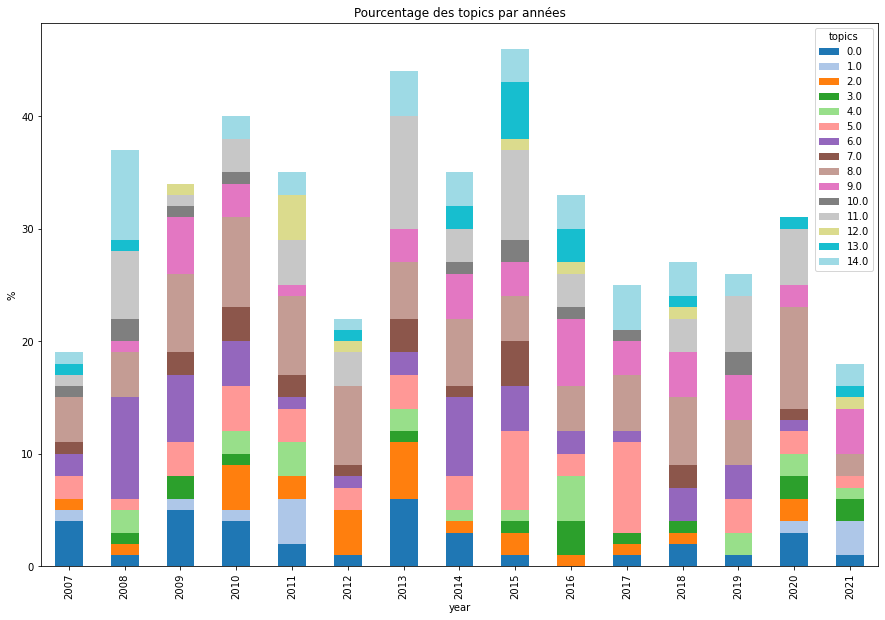

In [237]:
df3.groupby('year').topics.value_counts().unstack().plot(kind='bar', 
                                                                       stacked=True,
                                                                       figsize=(15,10), 
                                                                       legend=True,
                                                                       cmap='tab20',
                                                                       ylabel="%",
                                                                       title="Pourcentage des topics par années",
                                                                          );  #subplots=True, layout=(5, 4), 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
2007,6.896552,NaN,33.333333,NaN,5.0,8.823529,2.702703,NaN,5.555556,NaN,11.111111,2.777778,5.882353,NaN,5.882353,NaN,NaN,NaN,NaN,3.846154
2008,5.172414,NaN,NaN,14.285714,12.5,5.882353,21.621622,20.0,7.407407,NaN,NaN,13.888889,NaN,NaN,5.882353,5.0,NaN,NaN,NaN,7.692308
2009,12.068966,NaN,NaN,7.142857,2.5,8.823529,10.810811,5.0,5.555556,10.714286,NaN,NaN,5.882353,NaN,23.529412,NaN,14.285714,16.666667,8.333333,3.846154
2010,10.344828,10.0,NaN,14.285714,5.0,11.764706,2.702703,5.0,5.555556,7.142857,11.111111,8.333333,17.647059,NaN,17.647059,15.0,7.142857,16.666667,8.333333,3.846154
2011,8.620690,10.0,NaN,NaN,17.5,14.705882,2.702703,NaN,9.259259,3.571429,NaN,13.888889,NaN,NaN,NaN,15.0,NaN,NaN,8.333333,3.846154
2012,6.896552,NaN,NaN,7.142857,5.0,2.941176,2.702703,NaN,7.407407,7.142857,11.111111,5.555556,NaN,NaN,5.882353,5.0,NaN,NaN,NaN,7.692308
2013,12.068966,10.0,NaN,7.142857,12.5,2.941176,5.405405,10.0,7.407407,7.142857,22.222222,11.111111,NaN,NaN,23.529412,5.0,7.142857,16.666667,8.333333,15.384615
2014,3.448276,20.0,33.333333,NaN,5.0,2.941176,10.810811,15.0,7.407407,10.714286,11.111111,8.333333,NaN,9.090909,NaN,5.0,7.142857,25.000000,16.666667,3.846154
2015,12.068966,30.0,NaN,14.285714,5.0,5.882353,5.405405,20.0,9.259259,7.142857,11.111111,13.888889,11.764706,NaN,5.882353,15.0,7.142857,NaN,NaN,15.384615
2016,3.448276,NaN,NaN,7.142857,12.5,5.882353,2.702703,10.0,7.407407,7.142857,NaN,NaN,17.647059,18.181818,NaN,5.0,21.428571,NaN,25.000000,7.692308


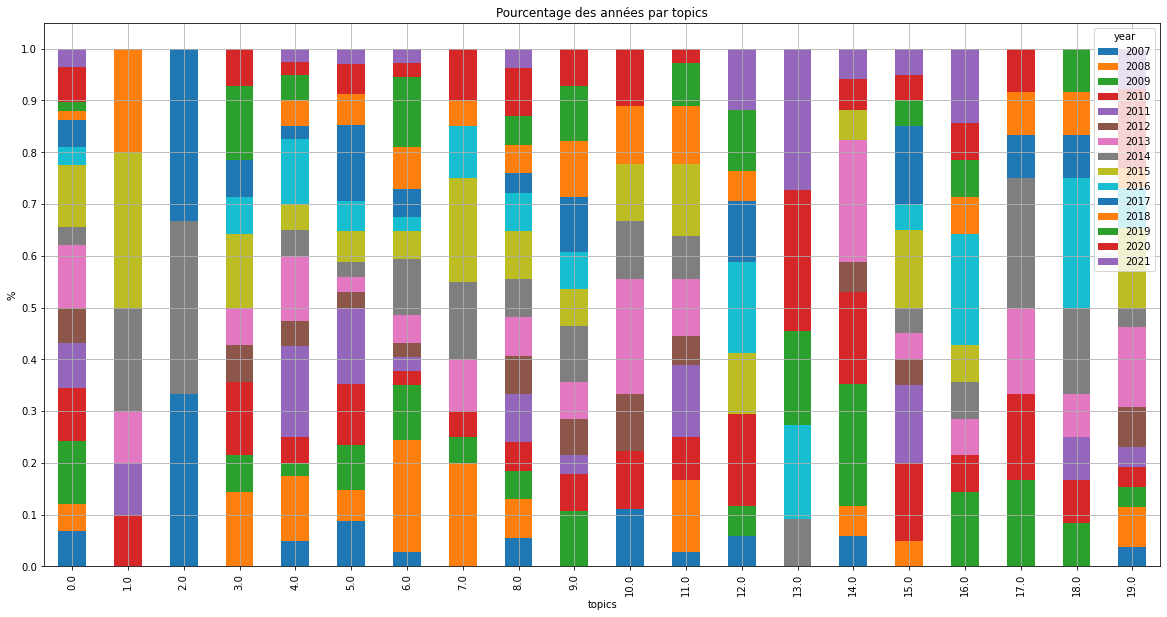

In [244]:
df3.groupby('topics').year.value_counts(normalize=True).unstack().plot(kind='bar', 
                                                                       stacked = True,
                                                                       figsize=(20,10), 
                                                                       legend=True, 
                                                                       grid=True,
                                                                       ylabel="%",
                                                                       title="Pourcentage des années par topics"
                                                                       ); #subplots=True, layout=(4,5),colormap='Spectral'
ax2 = df3.groupby('topics').year.value_counts(normalize=True).mul(100).unstack()
plt.yticks(np.arange(0, 1.1, 0.1));

#Spectral
#rainbow
#prism

tab2 = {}

for idx in ax2.index:
    test2 = []
    for i in ax2:
        test2.append(ax2[i].loc[idx])
    test2.append(sum(ax2.loc[idx].dropna()))
    tab2[idx] = test2
tab2 = pd.DataFrame(tab2)
tab2.transpose()
tab2.index = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 'Total']
tab2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


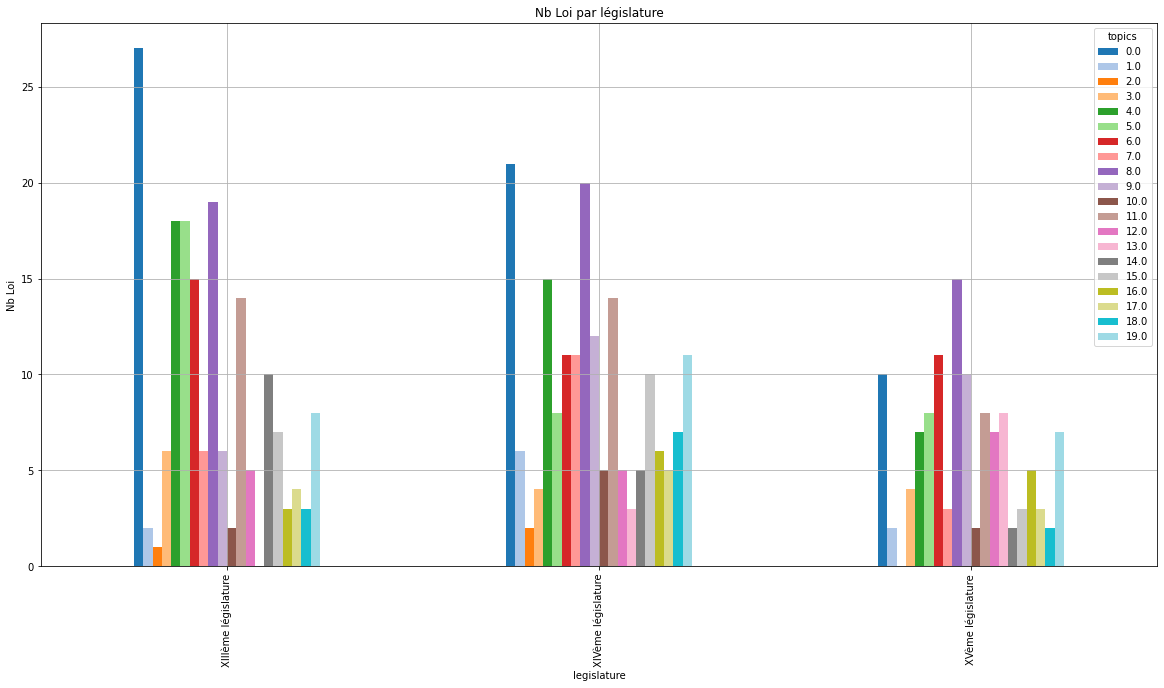

In [248]:
df3.groupby('legislature').topics.value_counts().unstack().plot(kind='bar', 
                                                                        figsize=(20,10),
                                                                        cmap='tab20',
                                                                        grid=True,
                                                                        ylabel="Nb Loi",
                                                                        title="Nb Loi par législature"
                                                                            ); #subplots=True, layout=(5,4),

In [272]:
df3.legislature.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XIVème législature     181
XIIIème législature    174
XVème législature      117
Name: legislature, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


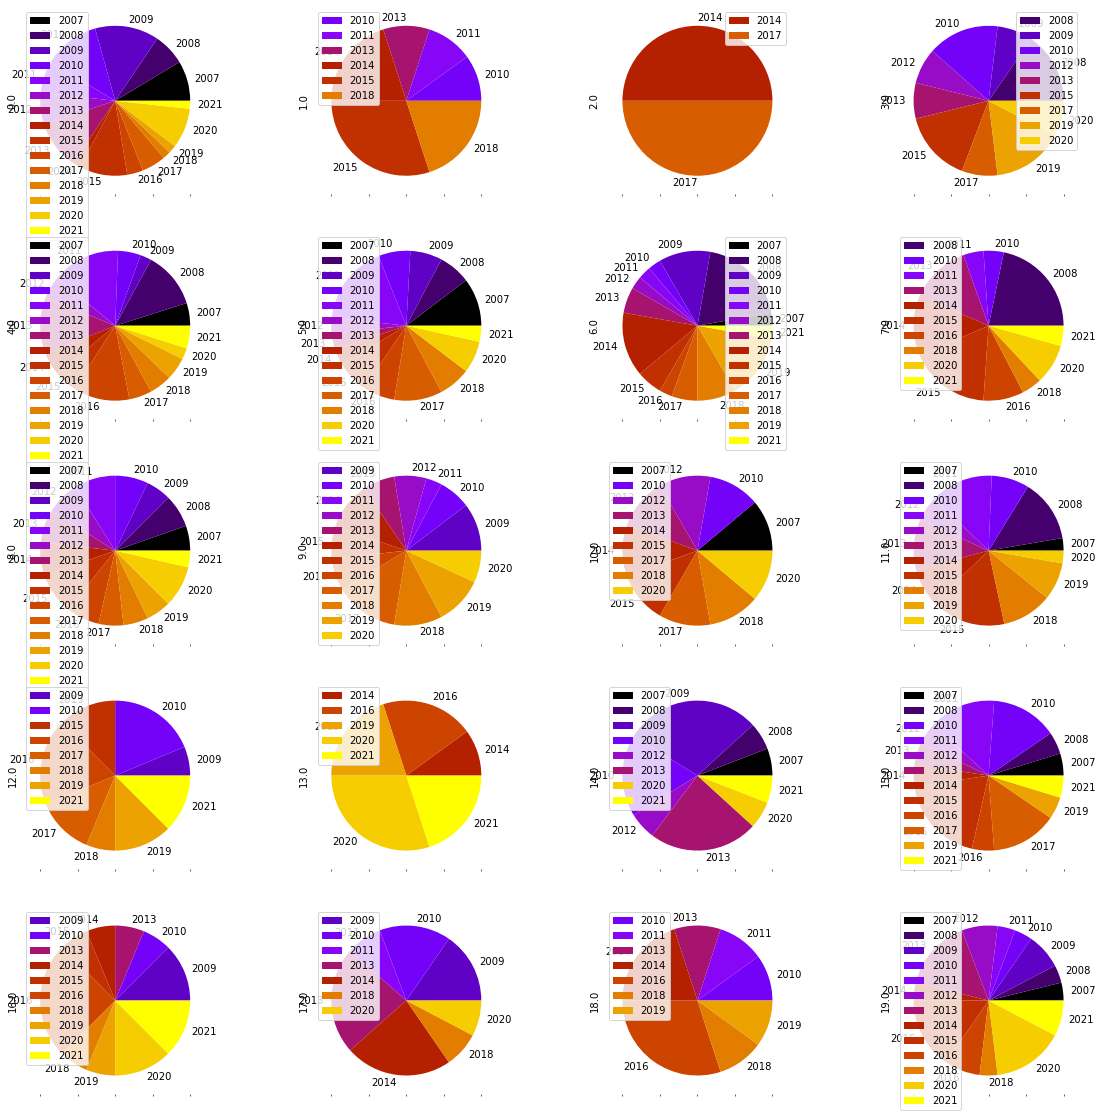

In [501]:
df3.groupby(['year']).topics.value_counts().unstack().plot(kind='pie', figsize=(20,20), subplots=True, layout=(5,4), colormap='gnuplot');
#area
#pie

# Visualisation topic par phrases

In [238]:
senttop = df_dominant_topic_novoid
senttop['year'] = ['' for i in range(len(senttop))]
senttop['legislature'] = ['' for i in range(len(senttop))]

for line in df_dominant_topic_novoid.index:
    senttop['year'].loc[line] = df3.year.loc[tmp[line]]
    senttop['legislature'].loc[line] = df3.legislature.loc[tmp[line]]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-238-7b3407811544>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senttop['year'] = ['' for i in range(len(senttop))]
<ipython-input-238-7b3407811544>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


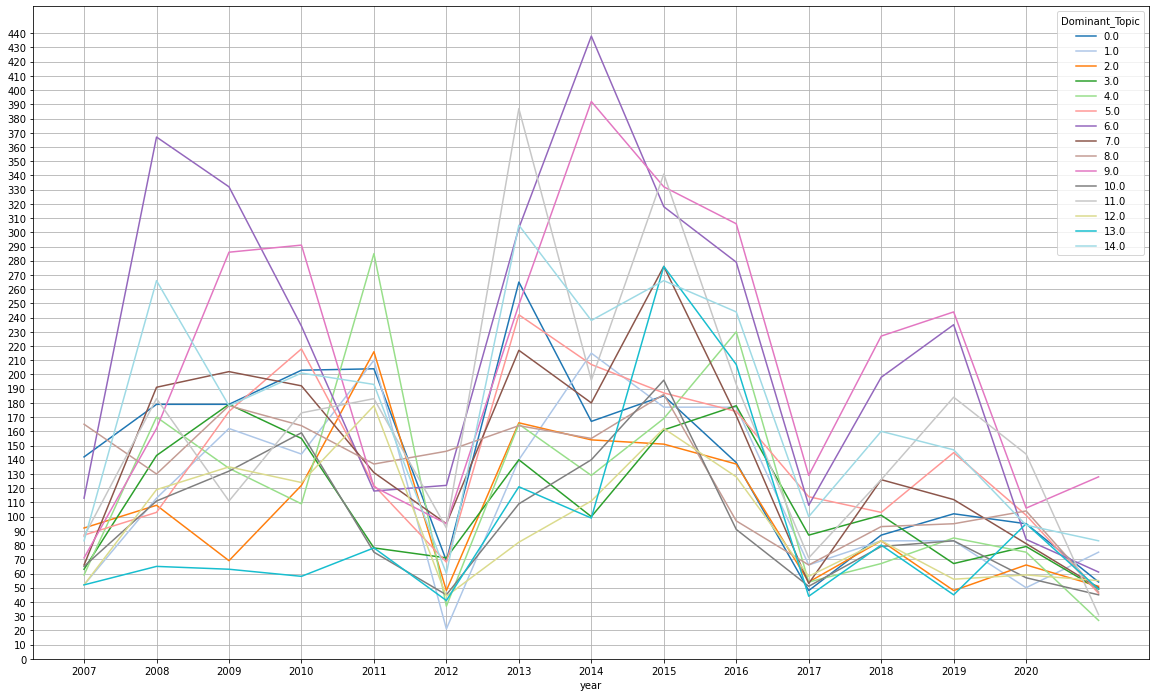

In [240]:
senttop.groupby('year').Dominant_Topic.value_counts().unstack().plot(kind='line', 
                                                                     subplots=False, 
                                                                     figsize=(20,12), 
                                                                     legend=True, 
                                                                     cmap='tab20',
                                                                     grid=True,
                                                                     #table=True,
                                                                        );
plt.yticks(np.arange(0, 450, 10));
plt.xticks(np.arange(2007, 2021, 1));

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


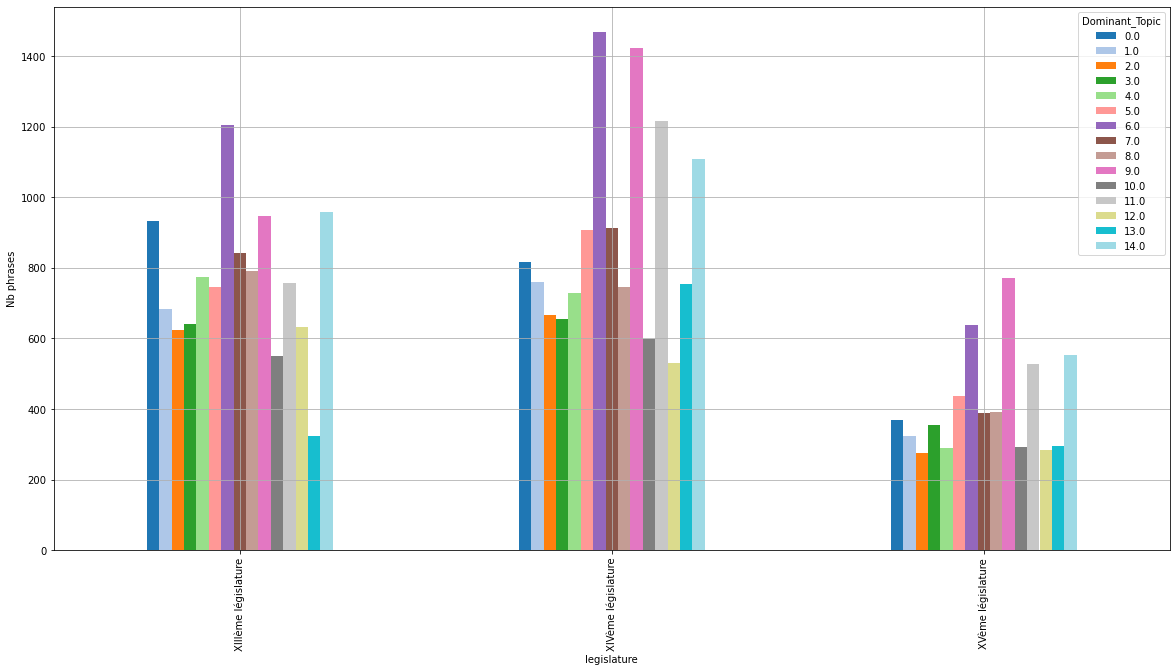

In [241]:
senttop.groupby('legislature').Dominant_Topic.value_counts().unstack().plot(kind='bar',
                                                                            #stacked=True,
                                                                            figsize=(20,10),  
                                                                            legend=True,
                                                                            cmap='tab20',
                                                                            ylabel="Nb phrases", 
                                                                            grid=True
                                                                                );
#plt.yticks(np.arange(0, 1100, 50));

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


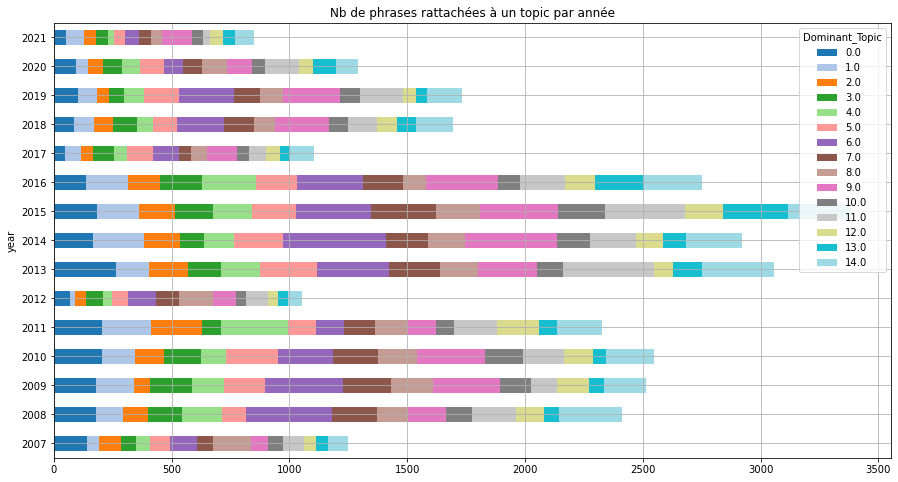

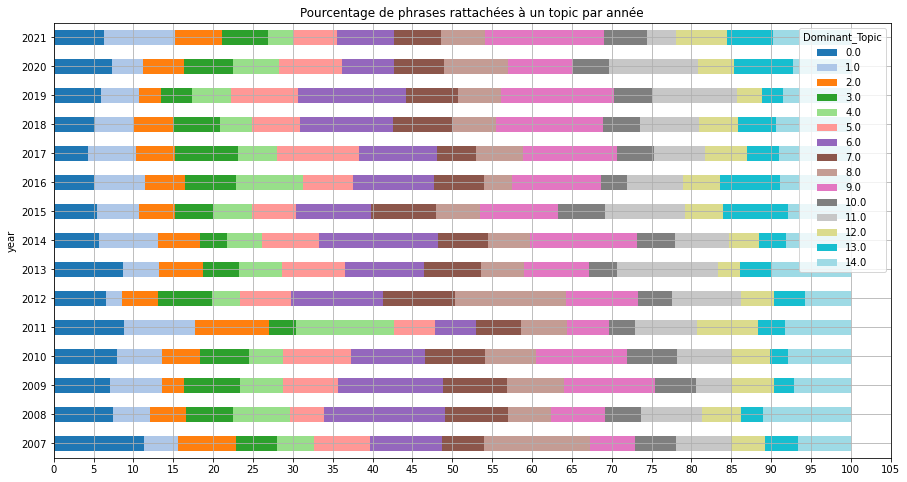

In [242]:
senttop.groupby('year').Dominant_Topic.value_counts().unstack().plot(kind='barh',
                                                                                   stacked=True,
                                                                                   #subplots=True, 
                                                                                   figsize=(15,8), 
                                                                                   #layout=(4,5), 
                                                                                   legend=True, 
                                                                                   colormap='tab20',
                                                                                   grid=True,
                                                                                   ylabel="Nb de phrase",
                                                                                   title="Nb de phrases rattachées à un topic par année");

senttop.groupby('year').Dominant_Topic.value_counts(normalize=True).mul(100).unstack().plot(kind='barh',
                                                                                   stacked=True,
                                                                                   #subplots=True, 
                                                                                   figsize=(15,8), 
                                                                                   #layout=(4,5), 
                                                                                   legend=True, 
                                                                                   colormap='tab20',
                                                                                   grid=True,
                                                                                   ylabel="%",
                                                                                   title="Pourcentage de phrases rattachées à un topic par année");
#plt.yticks(np.arange(0, 100, 5))
plt.xticks(np.arange(0, 110, 5));

In [243]:
senttop.Dominant_Topic.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6.0     3310
9.0     3139
14.0    2618
11.0    2501
7.0     2143
0.0     2117
5.0     2091
8.0     1927
4.0     1795
1.0     1768
3.0     1651
2.0     1565
12.0    1446
10.0    1438
13.0    1373
Name: Dominant_Topic, dtype: int64

# TEST - Collocations en fonction de l'année

On peut choisir des topics en particulier, mais nous travaillons ici sur tous les topics

In [244]:
senttop2 = senttop

for idx in senttop2.index:
    text = str(senttop2.Text.loc[idx])
    text = re.sub('\[', '', text)
    text = re.sub('\]', '', text)
    text = re.sub('\'', '', text)
    senttop2.Text.loc[idx] = text
senttop2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \]
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \]
<ipython-input-244-f06769041f7a>:5: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[', '', text)
<ipython-input-244-f06769041f7a>:6: DeprecationWarning: invalid escape sequence \]
  text = re.sub('\]', '', text)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,year,legislature
0,0,11.0,0.8066,"européen, France, parlement, directive, union,...","France, signer, Paris, accord, agence, spatial...",2015,XIVème législature
1,1,0.0,0.5294,"conseil, président, assemblée, organique, répu...","objet, accord, préciser",2015,XIVème législature
2,2,3.0,0.3299,"ministre, public, année, rapport, présenter, u...","modalité, terrain, CSG, agence, préciser, rela...",2015,XIVème législature
3,3,13.0,0.3798,"contre, international, étranger, lutte, séjour...","préciser, engagement, obligation, gouvernement...",2015,XIVème législature
4,4,11.0,0.5541,"européen, France, parlement, directive, union,...","France, garantir, abord, centre, national, étu...",2015,XIVème législature
...,...,...,...,...,...,...,...
31229,31229,8.0,0.2224,"finance, public, impôt, revenu, euro, fiscal, ...","proposer, pérenniser, remboursement, immédiat,...",2010,XIIIème législature
31230,31230,1.0,0.2789,"conséquence, tirer, bénéfice, prioritaire, com...","aide, accession, propriété, multiple, fusionne...",2010,XIIIème législature
31231,31231,6.0,0.2171,"entreprise, travail, société, emploi, professi...","développement, territoire, rural, encourager, ...",2010,XIIIème législature
31232,31232,10.0,0.2870,"vigueur, entrée, produit, transport, réseau, s...","décider, tirer, conséquence, crise, financier,...",2010,XIIIème législature


In [245]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = CountVectorizer()

law = {}

for year in senttop2.year.sort_values().unique():
    
    law_x = senttop2.Text.loc[senttop2.year == year].values
#    topics_x = senttop2.Dominant_Topic.loc[senttop2.year == year].values

    law[year] = law_x

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [249]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.tokenize import word_tokenize

for year in law:
    vectorizer = CountVectorizer(max_features=500)
    vectorizer.fit(law[year])
    X = vectorizer.transform(law[year])
    X = X.toarray()
    features = vectorizer.get_feature_names()
    (num_doc, num_f) = X.shape

    print(year, "Nombre de colonnes =", num_doc," mots : " + str(num_f))
    
    words = [w.lower() for xpo in law[year] for w in word_tokenize(xpo) if w.lower() != ',']

    for i, word in enumerate(words):
        words[i] = re.sub('\[', "", word)
        words[i] = re.sub('\]', "", word)
    
    bcf = BigramCollocationFinder.from_words(words)
    colloc = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)
    bgm = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(words)
    scored = bcf.score_ngrams(bgm.likelihood_ratio)
    #likelihood_ratio  #raw_freq
    
    for i, couple in enumerate(colloc):
        print(scored[i])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:18: DeprecationWarning: invalid escape sequence \[
<>:19: DeprecationWarning: invalid escape sequence \]
<>:18: DeprecationWarning: invalid escape sequence \[
<>:19: DeprecationWarning: invalid escape sequence \]
<ipython-input-249-c412168ba3aa>:18: DeprecationWarning: invalid escape sequence \[
  words[i] = re.sub('\[', "", word)
<ipython-input-249-c412168ba3aa>:19: DeprecationWarning: invalid escape sequence \]
  words[i] = re.sub('\]', "", word)


2007 Nombre de colonnes = 1248  mots : 500
(('polynésie', 'français'), 1061.1364105924742)
(('collectivité', 'territorial'), 403.8138285515203)
(('conseil', 'administration'), 348.6938245504781)
(('trafic', 'influence'), 303.2562483092807)
(('agent', 'public'), 286.9069857416363)
(('propriété', 'intellectuel'), 242.95216247318467)
(('pouvoir', 'achat'), 225.9761501690833)
(('assemblée', 'polynésie'), 221.4145612087455)
(('recette', 'fiscal'), 215.0869662063965)
(('enseignement', 'supérieur'), 211.17739384807618)
2008 Nombre de colonnes = 2410  mots : 500
(('assurance', 'chômage'), 459.9695805319497)
(('entrée', 'vigueur'), 343.35449611628655)
(('port', 'maritime'), 334.3740502587372)
(('collectivité', 'territorial'), 304.32733948496593)
(('demandeur', 'emploi'), 302.5319476165791)
(('port', 'autonome'), 279.9040001674919)
(('milliard', 'euro'), 263.3856873971757)
(('archive', 'public'), 263.0056253624328)
(('organisme', 'génétiquement'), 260.08293940772563)
(('prévention', 'réparation'

# Collocation par année, par topics

In [250]:
law_t = {}

for year in senttop2.year.sort_values().unique():
    law_t[year] = senttop2[['Dominant_Topic', 'year', 'Text']].loc[senttop2.year == year]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [251]:
def colloc_all(law):
    for year in law:
        print(year)
        df_year = law[year]
        for topic in df_year.Dominant_Topic.sort_values().unique():
            vec = df_year.Text.loc[df_year.Dominant_Topic==topic].values
#            print(vec[0])
            vectorizer = CountVectorizer(max_features=500)
            vectorizer.fit(vec)
            X = vectorizer.transform(vec)
            X = X.toarray()
            features = vectorizer.get_feature_names()
            (num_doc, num_f) = X.shape

            print(topic, "Nombre de colonnes =", num_doc," mots : " + str(num_f))
    
            co_occ = np.matmul(X_small.transpose(), X_small)

    
            words = [w.lower() for xpo in vec for w in word_tokenize(xpo) if w.lower() != ',']

            for i, word in enumerate(words):
                words[i] = re.sub('\[', "", word)
                words[i] = re.sub('\]', "", word)
    
            bcf = BigramCollocationFinder.from_words(words)
            colloc = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)
            bgm = nltk.collocations.BigramAssocMeasures()
            finder = BigramCollocationFinder.from_words(words)
            scored = bcf.score_ngrams(bgm.likelihood_ratio)
                                            #likelihood_ratio  #raw_freq
    
            for i, couple in enumerate(colloc):
                print(scored[i])
            temp = [dico[tops[0]] for tops in ldamodel.get_topic_terms(int(topic))]
            print(topic, ":", temp)
#            print(temp)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:23: DeprecationWarning: invalid escape sequence \[
<>:24: DeprecationWarning: invalid escape sequence \]
<>:23: DeprecationWarning: invalid escape sequence \[
<>:24: DeprecationWarning: invalid escape sequence \]
<ipython-input-251-8b8864e80297>:23: DeprecationWarning: invalid escape sequence \[
  words[i] = re.sub('\[', "", word)
<ipython-input-251-8b8864e80297>:24: DeprecationWarning: invalid escape sequence \]
  words[i] = re.sub('\]', "", word)


In [198]:
colloc_all(law_t)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2007
0.0 Nombre de colonnes = 153  mots : 500
(('polynésie', 'français'), 669.4649503357708)
(('conseil', 'administration'), 132.42903442867294)
(('assemblée', 'polynésie'), 124.47403105490324)
(('statut', 'autonomie'), 93.93024462653433)
(('étude', 'vie'), 89.49796272643086)
(('vie', 'universitaire'), 77.3961630156605)
(('lo', 'lo'), 70.914147150992)
(('stabilité', 'institution'), 64.37479814248842)
(('membre', 'gouvernement'), 63.32069856172349)
(('licence', 'obligatoire'), 60.88470077845274)
0.0 : ['conseil', 'président', 'république', 'français', 'pouvoir', 'assemblée', 'organique', 'décision', 'préciser', 'gouvernement']
1.0 Nombre de colonnes = 31  mots : 258
(('champ', 'application'), 51.413368710911044)
(('personnel', 'judiciaire'), 29.892116457917535)
(('agriculture', 'pêche'), 24.55493545364132)
(('profession', 'réglementer'), 24.55493545364132)
(('trafic', 'influence'), 24.55493545364132)
(('entrer', 'champ'), 23.80578580434028)
(('contrat', 'accueil'), 20.735850443872444)
(

(('collectivité', 'territorial'), 129.01194877936945)
(('réclusion', 'détention'), 49.816709248879945)
(('euro', 'amende'), 44.81268501349774)
(('acquérir', 'épargner'), 39.09265302477953)
(('indemnisation', 'jour'), 39.09265302477953)
(('jour', 'acquérir'), 39.09265302477953)
(('prélèvement', 'recette'), 39.09265302477953)
(('territorial', 'corse'), 32.763421573497524)
(('seuil', 'minimal'), 32.634031062263325)
(('pouvoir', 'prononcer'), 32.362536354686966)
15.0 : ['collectivité', 'territorial', 'local', 'département', 'représentant', 'cour', 'outre-mer', 'général', 'régional', 'région']
16.0 Nombre de colonnes = 58  mots : 394
(('circonstance', 'aggravant'), 33.54094733967768)
(('commettre', 'circonstance'), 29.045476456978854)
(('aggravant', 'violence'), 28.478915030821547)
(('masse', 'salarial'), 26.984811060941013)
(('modalité', 'prise'), 26.984811060941013)
(('réclusion', 'détention'), 26.984811060941013)
(('sixième', 'alinéa'), 26.984811060941013)
(('conseil', 'administration'),

11.0 Nombre de colonnes = 157  mots : 500
(('union', 'européen'), 114.194087330505)
(('fusion', 'transfrontalier'), 100.44290929202144)
(('immatriculer', 'france'), 67.3828031366518)
(('transposer', 'directive'), 63.93936963761965)
(('communauté', 'européen'), 59.31885647668592)
(('cour', 'justice'), 51.7309767246484)
(('port', 'maritime'), 47.95248045705389)
(('grand', 'port'), 46.4571173067079)
(('journal', 'officiel'), 44.27903934811392)
(('information', 'consultation'), 39.78035819116345)
11.0 : ['européen', 'directive', 'France', 'parlement', 'union', 'membre', 'conseil', 'français', 'société', 'UE']
12.0 Nombre de colonnes = 88  mots : 500
(('archive', 'public'), 67.64348008808169)
(('journal', 'officiel'), 41.04094014838059)
(('publier', 'journal'), 41.04094014838059)
(('maîtrise', 'uvre'), 33.70298562384402)
(('contribuer', 'stabiliser'), 28.984426435961822)
(('service', 'public'), 26.81909422939157)
(('assistance', 'technique'), 25.1653414261934)
(('courant', 'intermédiaire'),

(('question', 'constitutionnalité'), 72.20130914772182)
(('accès', 'internet'), 62.48611818566054)
(('tirer', 'conséquence'), 62.48611818566054)
(('aviation', 'civil'), 47.20355926675658)
(('rédactionnel', 'cohérence'), 43.72529147268321)
(('cour', 'cassation'), 43.35674267549838)
(('annulation', 'réformation'), 39.22661031573274)
(('pécuniaire', 'montant'), 39.22661031573274)
(('tribunal', 'administratif'), 37.34242453447207)
(('prévenir', 'renouvellement'), 36.99517480259065)
4.0 : ['peine', 'pénal', 'administratif', 'conséquence', 'modification', 'judiciaire', 'juridiction', 'pouvoir', 'personne', 'supprimer']
5.0 Nombre de colonnes = 171  mots : 500
(('agence', 'régional'), 115.02527322838404)
(('fonction', 'public'), 89.97933913453448)
(('régional', 'santé'), 81.99644777579145)
(('prise', 'charge'), 66.00131668700595)
(('sécurité', 'social'), 50.237316431217806)
(('assurance', 'maladie'), 48.705120077350294)
(('conseil', 'surveillance'), 43.861699758469825)
(('secret', 'défense'),

(('conseil', 'supérieur'), 308.26136792612175)
(('économique', 'social'), 136.51193025523855)
(('magistrat', 'siège'), 124.78356686418442)
(('supérieur', 'magistrature'), 122.28942303619887)
(('garde', 'sceau'), 109.39201542023208)
(('magistrat', 'parquet'), 88.19708744733106)
(('emploi', 'fonction'), 82.51306945799374)
(('poursuite', 'disciplinaire'), 79.18879125236309)
(('sceau', 'ministre'), 75.2647008109179)
(('social', 'environnemental'), 75.2647008109179)
0.0 : ['conseil', 'président', 'république', 'français', 'pouvoir', 'assemblée', 'organique', 'décision', 'préciser', 'gouvernement']
1.0 Nombre de colonnes = 123  mots : 500
(('tarif', 'réglementer'), 105.65441812994854)
(('réglementer', 'vente'), 95.65756471544836)
(('développement', 'durable'), 87.45930974318706)
(('directive', 'territorial'), 71.68682129941581)
(('accès', 'réguler'), 68.43833880240095)
(('conjoint', 'collaborateur'), 68.43833880240095)
(('plan', 'local'), 49.86685837791235)
(('grand', 'paris'), 48.8999682743

(('permis', 'construire'), 54.56808016934711)
(('pari', 'sportif'), 54.02551285936605)
(('accès', 'réguler'), 47.20679602597717)
(('centrale', 'nucléaire'), 47.20679602597717)
(('électricité', 'base'), 46.95896765111114)
(('pari', 'hippique'), 45.068079008499154)
(('crédit', 'consommation'), 44.64747257500239)
(('réguler', 'électricité'), 40.02667817278201)
(('régime', 'retraite'), 38.862930960823036)
(('lieu', 'vente'), 36.670318015566295)
14.0 : ['financier', 'retraite', 'investissement', 'effort', 'régime', 'montant', 'logement', 'crédit', 'fonds', 'coût']
15.0 Nombre de colonnes = 118  mots : 500
(('collectivité', 'territorial'), 174.61118512499223)
(('général', 'collectivité'), 68.79750039247031)
(('partie', 'général'), 44.882075459523286)
(('département', 'mayotte'), 43.2467249180425)
(('assemblée', 'délibérant'), 42.99880523749701)
(('cour', 'cassation'), 42.66217554395997)
(('secret', 'source'), 38.50012408054654)
(('concomitance', 'renouvellement'), 34.68103907077767)
(('dépar

(('destruction', 'massif'), 152.7168711079658)
(('arme', 'destruction'), 129.01798682437692)
(('lutte', 'contre'), 118.36187105753191)
(('donnée', 'identifiant'), 84.89508880269764)
(('prolifération', 'arme'), 73.4923094862673)
(('assistance', 'médical'), 71.51529032712216)
(('médical', 'procréation'), 71.51529032712216)
(('soin', 'consentement'), 60.5258685563937)
(('acte', 'authentique'), 52.79559771705944)
(('contre', 'prolifération'), 48.56324771010547)
10.0 : ['séjour', 'demande', 'acte', 'étranger', 'résulter', 'rédaction', 'préalable', 'appliquer', 'international', 'amende']
11.0 Nombre de colonnes = 139  mots : 500
(('parlement', 'européen'), 204.09727669632105)
(('union', 'européen'), 132.64235454524658)
(('transposition', 'directive'), 129.98120687672298)
(('marché', 'intérieur'), 123.97509080730995)
(('européen', 'conseil'), 100.2264440061519)
(('carte', 'bleu'), 98.16804988883186)
(('pays', 'tiers'), 97.12915306293931)
(('directive', 'parlement'), 81.72470745518962)
(('serv

5.0 Nombre de colonnes = 51  mots : 400
(('sécurité', 'social'), 74.42495367397485)
(('fonction', 'public'), 69.5613726563393)
(('assurance', 'maladie'), 36.58993709997161)
(('limite', 'âge'), 34.151489847565905)
(('établissement', 'public'), 30.507571162171985)
(('financement', 'sécurité'), 28.06515919398836)
(('mettre', 'uvre'), 27.427174487851282)
(('convergent', 'coordonnée'), 27.39152988635007)
(('crise', 'apporter'), 27.39152988635007)
(('industriel', 'commercial'), 27.39152988635007)
5.0 : ['public', 'principe', 'santé', 'fonction', 'sécurité', 'national', 'défense', 'social', 'poser', 'général']
6.0 Nombre de colonnes = 102  mots : 500
(('emploi', 'avenir'), 91.17095945601326)
(('fonction', 'public'), 65.56135384620569)
(('partenaire', 'social'), 60.628503547844815)
(('catégorie', 'hiérarchique'), 43.4513928050671)
(('collectivité', 'territorial'), 42.99154491923977)
(('répondre', 'besoin'), 38.26831535619679)
(('contribution', 'versement'), 36.72127613497453)
(('emploi', 'titu

0.0 : ['conseil', 'président', 'république', 'français', 'pouvoir', 'assemblée', 'organique', 'décision', 'préciser', 'gouvernement']
1.0 Nombre de colonnes = 121  mots : 500
(('monnaie', 'électronique'), 289.75418624948406)
(('émission', 'gestion'), 57.11380689675221)
(('établissement', 'monnaie'), 54.484919542930626)
(('développement', 'durable'), 53.83587509608102)
(('affaire', 'maritime'), 43.68798950771641)
(('contrôleur', 'affaire'), 43.68798950771641)
(('recueil', 'soutien'), 43.58139187762181)
(('service', 'paiement'), 40.25271360672252)
(('gestion', 'monnaie'), 39.62715134464465)
(('émetteur', 'monnaie'), 39.62715134464465)
1.0 : ['aide', 'champ', 'développement', 'aménagement', 'plan', 'critère', 'exploitation', 'commerce', 'reconnaissance', 'durable']
2.0 Nombre de colonnes = 66  mots : 478
(('femme', 'homme'), 58.12526616627851)
(('universel', 'direct'), 50.16344849315972)
(('suffrage', 'universel'), 45.15942425777784)
(('égal', 'accès'), 40.157980668273424)
(('situation', 

(('collectivité', 'territorial'), 81.6086602999296)
(('emprisonnement', 'amende'), 61.60884607475201)
(('singulier', 'pluriel'), 53.296732355050636)
(('cour', 'cassation'), 50.52218848955107)
(('conseil', 'départemental'), 38.13948640431889)
(('conseil', 'administration'), 37.72293694257738)
(('personnalité', 'qualifier'), 37.202567729711035)
(('peine', 'emprisonnement'), 36.7029895498017)
(('conseil', 'général'), 32.79026790305362)
(('mettre', 'uvre'), 32.14053542085439)
15.0 : ['collectivité', 'territorial', 'local', 'département', 'représentant', 'cour', 'outre-mer', 'général', 'régional', 'région']
16.0 Nombre de colonnes = 174  mots : 500
(('mettre', 'uvre'), 87.90966685300543)
(('transport', 'routier'), 84.55561529866247)
(('lutte', 'contre'), 60.94444068435173)
(('socle', 'commun'), 57.74864841494415)
(('circonstance', 'aggravant'), 45.98517806939794)
(('refondation', 'école'), 45.84409646980062)
(('collectivité', 'territorial'), 41.48649691244642)
(('progressivité', 'apprentiss

9.0 Nombre de colonnes = 285  mots : 500
(('social', 'solidaire'), 149.29435641134904)
(('économie', 'social'), 144.46016269228667)
(('système', 'retraite'), 114.24836900552033)
(('gestionnaire', 'infrastructure'), 108.0674270247946)
(('modèle', 'ocde'), 97.52887134443971)
(('accessibilité', 'programmer'), 81.90909686876512)
(('agenda', 'accessibilité'), 81.90909686876512)
(('issu', 'commentaire'), 65.17257021117345)
(('solidarité', 'international'), 63.04526677538546)
(('développement', 'solidarité'), 62.5415907013094)
9.0 : ['social', 'réforme', 'économique', 'secteur', 'société', 'objectif', 'assurer', 'financement', 'modèle', 'évolution']
10.0 Nombre de colonnes = 67  mots : 500
(('acte', 'terrorisme'), 51.8893914168036)
(('échange', 'renseignement'), 39.72602401127405)
(('bord', 'navire'), 32.99590734118185)
(('conclure', 'france'), 28.108290928238574)
(('dioxyde', 'carbone'), 28.108290928238574)
(('autorité', 'administratif'), 24.289205918469698)
(('délit', 'provocation'), 24.289

(('métropole', 'lyon'), 84.15630840273869)
(('communauté', 'urbain'), 67.25217311841006)
(('établissement', 'public'), 57.1237280133464)
(('foncier', 'aménagement'), 56.66716130788235)
(('mutualiser', 'fonds'), 55.589497872596844)
(('arme', 'relever'), 50.58547363721497)
(('promotion', 'fonctionnel'), 50.58547363721497)
(('département', 'rhône'), 44.499142983637725)
(('relever', 'catégorie'), 42.12926453241172)
(('exercer', 'activité'), 39.76013696165634)
3.0 : ['établissement', 'contrat', 'public', 'durée', 'enseignement', 'ouvrir', 'Paris', 'agent', 'catégorie', 'service']
4.0 Nombre de colonnes = 171  mots : 500
(('union', 'européen'), 73.45564020459261)
(('affaire', 'familial'), 60.785775202390944)
(('guyane', 'martinique'), 60.55818380101944)
(('huissier', 'justice'), 57.428397023209186)
(('habiliter', 'gouvernement'), 52.4151991438906)
(('faire', 'objet'), 46.935835499285474)
(('commissaire-priseur', 'judiciaire'), 46.35066583600927)
(('perte', 'autonomie'), 39.15990294070842)
((

(('austral', 'antarctique'), 64.89350153058407)
(('terre', 'austral'), 64.89350153058407)
(('antarctique', 'français'), 45.01873754481571)
(('polynésie', 'français'), 45.01873754481571)
(('courant', 'circulation'), 42.00601197655279)
(('modèle', 'ocde'), 42.00601197655279)
(('ministre', 'charger'), 37.87806661512206)
(('selon', 'lequel'), 37.50733081960232)
(('circulation', 'capital'), 33.68824580983345)
(('paiement', 'courant'), 33.68824580983345)
17.0 : ['ministre', 'modalité', 'public', 'présenter', 'société', 'nouveau', 'conseiller', 'déterminer', 'obligation', 'Mayotte']
18.0 Nombre de colonnes = 160  mots : 500
(('gaz', 'serre'), 132.6520531422581)
(('zone', 'euro'), 91.31017267608226)
(('perte', 'autonomie'), 89.2632732123752)
(('secrétariat', 'ccnucc'), 71.91489945387836)
(('personne', 'âgé'), 71.47856672111)
(('émission', 'gaz'), 70.60691156283289)
(('intégration', 'marché'), 51.20721728450191)
(('financier', 'sein'), 46.480078925287835)
(('fragmentation', 'financier'), 46.480

(('métier', 'artisanat'), 84.64440764689228)
(('chambre', 'métier'), 61.682392407503514)
(('conflit', 'intérêt'), 58.1429878465289)
(('service', 'public'), 46.48381442179269)
(('caractère', 'personnel'), 45.93384061372659)
(('relation', 'contractuel'), 41.54760051209121)
(('directement', 'indirectement'), 40.953167938641926)
(('sérieux', 'penser'), 40.953167938641926)
(('base', 'donnée'), 37.51890848044742)
(('propriété', 'personne'), 35.97435185208636)
12.0 : ['public', 'service', 'commune', 'donnée', 'intérêt', 'personne', 'égalité', 'relation', 'accès', 'ministère']
13.0 Nombre de colonnes = 174  mots : 500
(('lutte', 'contre'), 264.39819995724883)
(('lutter', 'contre'), 56.00224837432114)
(('agence', 'français'), 53.74101582082636)
(('changement', 'climatique'), 51.121430494429)
(('contre', 'terrorisme'), 47.52673796381288)
(('péril', 'imminent'), 46.18097040987088)
(('crime', 'organiser'), 42.07758962879617)
(('carte', 'séjour'), 41.68228925291933)
(('pollution', 'air'), 41.682289

(('tissu', 'cellule'), 62.337776602227564)
(('activité', 'conseil'), 37.641531593866205)
(('partie', 'législatif'), 34.473610019386875)
(('pays', 'tiers'), 33.74390417950858)
(('ratifier', 'partie'), 30.913307383794958)
(('importer', 'tissu'), 29.24949881294244)
(('aide', 'social'), 28.606672438495835)
(('assistance', 'éducatif'), 28.606672438495835)
(('poser', 'principe'), 28.606672438495835)
(('profession', 'libéral'), 28.606672438495835)
7.0 : ['pouvoir', 'faire', 'objet', 'personne', 'tel', 'soumettre', 'obligation', 'produit', 'lorsque', 'autorité']
8.0 Nombre de colonnes = 46  mots : 338
(('milliard', 'euro'), 119.08922006765752)
(('finance', 'rectificatif'), 52.47789941701982)
(('entrée', 'vigueur'), 40.70921704133646)
(('prélèvement', 'source'), 38.34258008261546)
(('déposer', 'devant'), 37.99147405200056)
(('tissu', 'cellule'), 37.99147405200056)
(('chiffre', 'affaire'), 33.49279289505009)
(('impôt', 'revenu'), 31.377698886238612)
(('devant', 'parlement'), 31.26135738190799)
(

(('réalisation', 'opération'), 48.63110775851708)
(('durée', 'maximal'), 43.43445568999523)
(('partenarial', 'aménagement'), 39.52253148901989)
(('cohérence', 'objectif'), 29.58438343413463)
(('cotisation', 'contribution'), 29.58438343413463)
(('rémunération', 'inférieur'), 29.58438343413463)
(('siège', 'pourvoir'), 29.58438343413463)
(('opération', 'aménagement'), 27.735985609663565)
(('salarié', 'rémunération'), 25.765298424365753)
(('comité', 'international'), 24.039205989655066)
3.0 : ['établissement', 'contrat', 'public', 'durée', 'enseignement', 'ouvrir', 'Paris', 'agent', 'catégorie', 'service']
4.0 Nombre de colonnes = 116  mots : 500
(('tirer', 'conséquence'), 64.4445418933375)
(('habiliter', 'gouvernement'), 54.03048287047083)
(('tribunal', 'administratif'), 52.77869004517021)
(('liberté', 'détention'), 46.029218878479334)
(('assignation', 'résidence'), 43.396309952782005)
(('modification', 'apporter'), 41.607056004738325)
(('devant', 'cnda'), 39.93203333295526)
(('séjour', '

(('action', 'public'), 60.24314997831148)
(('ministre', 'action'), 49.24360989814568)
(('mode', 'preuve'), 46.49439286756561)
(('économie', 'finance'), 28.941001119963865)
(('ministre', 'économie'), 27.985943998267338)
(('consultation', 'accession'), 27.781681292278734)
(('lp', 'apf'), 27.781681292278734)
(('plein', 'souveraineté'), 27.781681292278734)
(('choix', 'clair'), 23.962596282509853)
(('pays', 'lp'), 23.962596282509853)
17.0 : ['ministre', 'modalité', 'public', 'présenter', 'société', 'nouveau', 'conseiller', 'déterminer', 'obligation', 'Mayotte']
18.0 Nombre de colonnes = 95  mots : 500
(('système', 'information'), 96.11419815165014)
(('partie', 'prenant'), 55.171732028625655)
(('ouverture', 'concurrence'), 42.806423649873835)
(('sécurité', 'système'), 42.59753562925896)
(('attendre', 'formation'), 38.60827262807231)
(('renouvellement', 'urbain'), 31.880909831157524)
(('autorité', 'national'), 30.631648939882417)
(('attaque', 'informatique'), 30.36120387831178)
(('chemin', 'f

13.0 Nombre de colonnes = 71  mots : 500
(('ressource', 'humain'), 41.20043617702027)
(('espace', 'naturel'), 37.022363989532984)
(('périmètre', 'protection'), 37.0144510269039)
(('biodiversité', 'ensemble'), 35.26656133524699)
(('lutte', 'contre'), 34.21702570218143)
(('restauration', 'ressource'), 30.36213056174628)
(('faune', 'sauvage'), 28.92192514447893)
(('importance', 'continuer'), 28.92192514447893)
(('ministère', 'transition'), 28.92192514447893)
(('part', 'autorité'), 28.92192514447893)
13.0 : ['contre', 'protection', 'sanitaire', 'lutte', 'environnement', 'urgence', 'renforcer', 'crise', 'section', 'viser']
14.0 Nombre de colonnes = 55  mots : 496
(('changement', 'irrégulier'), 27.91554199139924)
(('conclusion', 'tendre'), 27.91554199139924)
(('irrégulier', 'usage'), 27.91554199139924)
(('lui-même', 'appeler'), 27.91554199139924)
(('offre', 'lancer'), 27.91554199139924)
(('poursuivre', 'objectif'), 27.91554199139924)
(('prendre', 'conclusion'), 27.91554199139924)
(('sanction

(('crise', 'sanitaire'), 47.41964743627345)
(('habiliter', 'gouvernement'), 47.41964743627345)
(('enseignement', 'supérieur'), 41.0467541064186)
(('responsabilité', 'élargir'), 36.54807294946813)
(('élargir', 'producteur'), 36.54807294946813)
(('personnel', 'navigant'), 34.31663743632603)
(('activité', 'partiel'), 33.971104339745914)
(('audience', 'syndical'), 28.98830052948597)
(('aéronautique', 'civil'), 28.98830052948597)
(('homme', 'membre'), 28.98830052948597)
6.0 : ['entreprise', 'emploi', 'professionnel', 'travail', 'salarié', 'formation', 'imposition', 'social', 'mieux', 'employeur']
7.0 Nombre de colonnes = 93  mots : 500
(('procureur', 'européen'), 149.4057685306461)
(('liberté', 'détention'), 116.64861203728209)
(('juge', 'liberté'), 105.73656654186817)
(('européen', 'déléguer'), 100.23708868781782)
(('responsabilité', 'élargir'), 65.5291863687252)
(('élargir', 'producteur'), 65.5291863687252)
(('devant', 'juge'), 45.405600309719425)
(('principe', 'responsabilité'), 45.27351

(('action', 'extérieur'), 24.805017555449083)
(('agence', 'français'), 24.805017555449083)
(('agricole', 'soutenir'), 24.805017555449083)
(('schéma', 'régional'), 24.805017555449083)
(('développement', 'durable'), 16.429243315255484)
(('français', 'développement'), 16.429243315255484)
(('absence', 'entraîner'), 13.791557963265474)
(('accompagner', 'transformation'), 13.791557963265474)
(('acquérir', 'intéressé'), 13.791557963265474)
(('activité', 'cérébral'), 13.791557963265474)
1.0 : ['aide', 'champ', 'développement', 'aménagement', 'plan', 'critère', 'exploitation', 'commerce', 'reconnaissance', 'durable']
2.0 Nombre de colonnes = 24  mots : 237
(('énergie', 'renouvelable'), 24.788348070837753)
(('association', 'cultuel'), 24.147803382027867)
(('charger', 'formuler'), 24.147803382027867)
(('collectivité', 'territorial'), 24.147803382027867)
(('coût', 'vie'), 24.147803382027867)
(('référence', 'indice'), 24.147803382027867)
(('développement', 'communauté'), 20.328718372258987)
(('form

(('contre', 'inégalité'), 72.27337944750083)
(('lutte', 'contre'), 72.27337944750083)
(('inégalité', 'mondial'), 51.24525791001453)
(('solidaire', 'lutte'), 51.24525791001453)
(('politique', 'développement'), 42.41360708759901)
(('crédit', 'budgétaire'), 40.305452078533534)
(('président', 'république'), 40.305452078533534)
(('transition', 'écologique'), 37.014159593566205)
(('développement', 'durable'), 36.59982581079658)
(('collectivité', 'territorial'), 35.80677092158307)
16.0 : ['développement', 'uvre', 'mettre', 'transport', 'nouveau', 'recherche', 'programmation', 'programme', 'politique', 'moyen']
17.0 Nombre de colonnes = 27  mots : 230
(('finances', 'relance'), 43.180196076008414)
(('économie', 'finances'), 43.180196076008414)
(('ministre', 'économie'), 33.619482610201814)
(('déléguer', 'auprès'), 24.374994530234588)
(('tirage', 'sort'), 24.374994530234588)
(('consultation', 'public'), 21.903193760267776)
(('général', 'impôt'), 20.555909520465708)
(('société', 'civil'), 20.5559

In [579]:
def colloc_by_top(law, topic_nb):
    topic = topic_nb
    if topic not in law[2007].Dominant_Topic.unique():
        print("Error")
        return("Error, wrong topic in input")
    for year in law:
        print(year)
        df_year = law[year]
        vec = df_year.Text.loc[df_year.Dominant_Topic==topic].values
#        print(vec[0])
        vectorizer = CountVectorizer()
        vectorizer.fit(vec)
        X = vectorizer.transform(vec)
        X = X.toarray()
        (num_doc, num_f) = X.shape

        print(topic, "Nombre de colonnes =", num_doc," mots : " + str(num_f))
    
        words = [w.lower() for xpo in vec for w in word_tokenize(xpo) if w.lower() != ',']

        for i, word in enumerate(words):
            words[i] = re.sub('\[', "", word)
            words[i] = re.sub('\]', "", word)
    
        bcf = BigramCollocationFinder.from_words(words)
        colloc = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)
        bgm = nltk.collocations.BigramAssocMeasures()
        finder = BigramCollocationFinder.from_words(words)
        scored = bcf.score_ngrams(bgm.likelihood_ratio)
    #likelihood_ratio  #raw_freq
    
#        for i, couple in enumerate(colloc):
#            print(scored[i])
        temp = [dico[tops[0]] for tops in ldamodel.get_topic_terms(int(topic))]
        print(topic, ":", temp)
        
        plot = pd.DataFrame(scored[:10])
        plot.index = [w[0] for w in scored[:10]]
        plt.show(plot.plot(kind='barh', title=" 10 meilleures collocations en {} pour le topic {}".format(year, int(topic))))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:22: DeprecationWarning: invalid escape sequence \[
<>:23: DeprecationWarning: invalid escape sequence \]
<>:22: DeprecationWarning: invalid escape sequence \[
<>:23: DeprecationWarning: invalid escape sequence \]
<ipython-input-579-de24a66d6cd6>:22: DeprecationWarning: invalid escape sequence \[
  words[i] = re.sub('\[', "", word)
<ipython-input-579-de24a66d6cd6>:23: DeprecationWarning: invalid escape sequence \]
  words[i] = re.sub('\]', "", word)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2007
4 Nombre de colonnes = 59  mots : 367
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


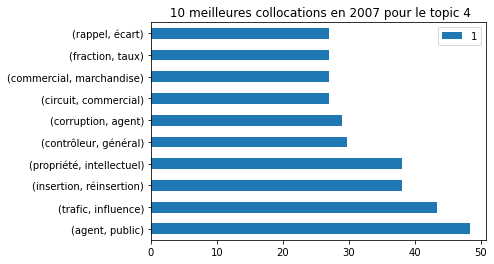

2008
4 Nombre de colonnes = 170  mots : 812
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


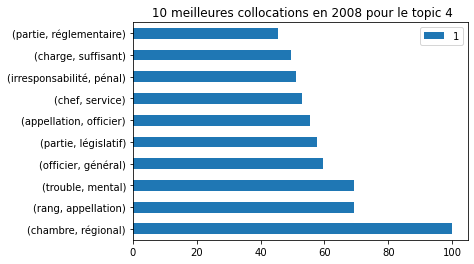

2009
4 Nombre de colonnes = 134  mots : 688
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


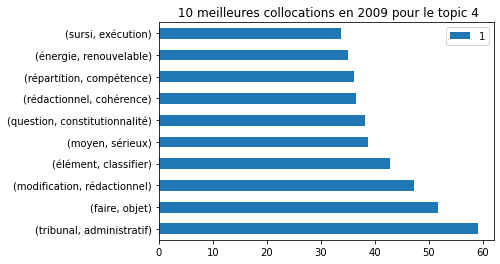

2010
4 Nombre de colonnes = 109  mots : 647
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


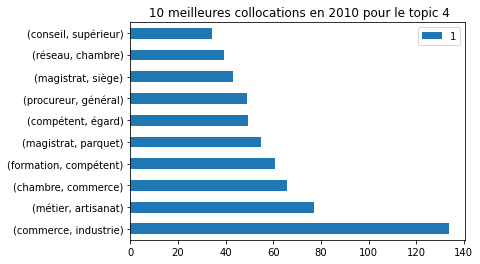

2011
4 Nombre de colonnes = 285  mots : 1213
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


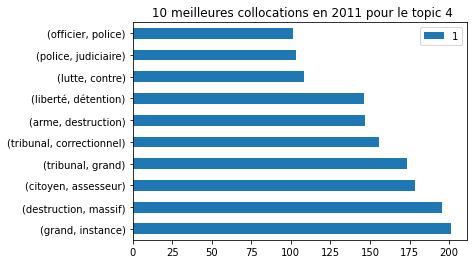

2012
4 Nombre de colonnes = 37  mots : 309
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


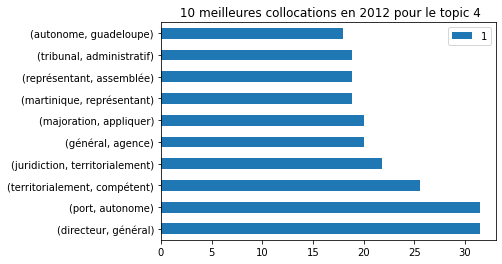

2013
4 Nombre de colonnes = 165  mots : 835
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


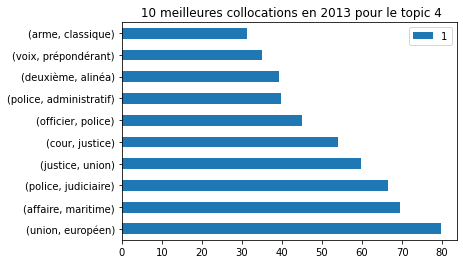

2014
4 Nombre de colonnes = 129  mots : 724
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


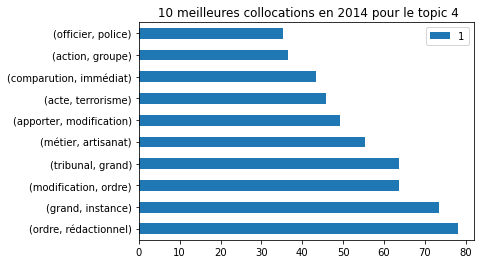

2015
4 Nombre de colonnes = 169  mots : 896
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


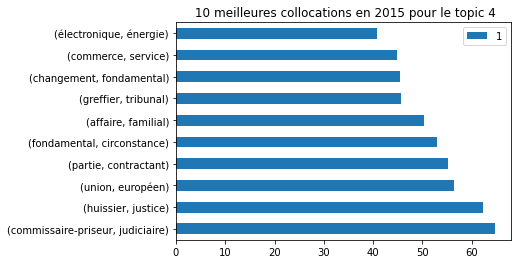

2016
4 Nombre de colonnes = 230  mots : 1189
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


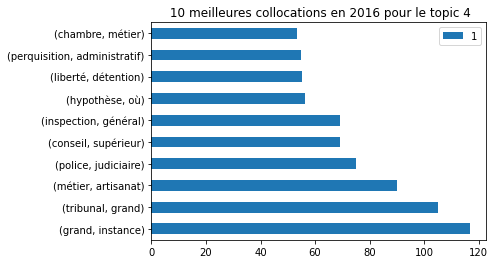

2017
4 Nombre de colonnes = 54  mots : 430
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


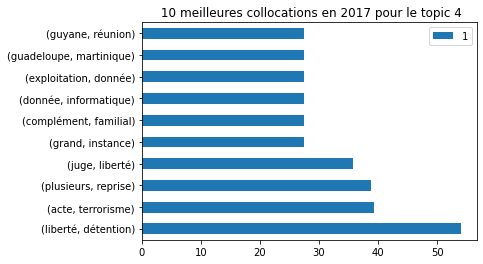

2018
4 Nombre de colonnes = 67  mots : 494
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


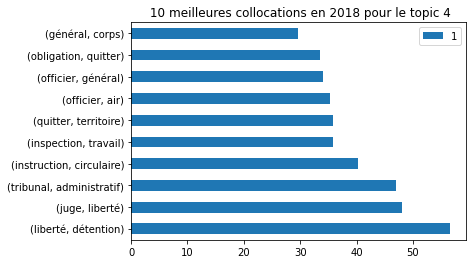

2019
4 Nombre de colonnes = 85  mots : 576
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


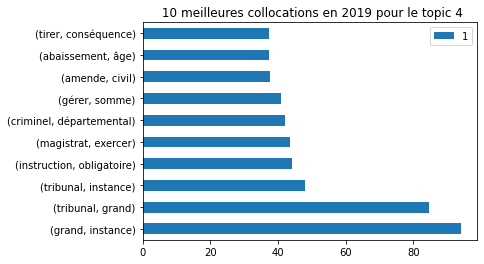

2020
4 Nombre de colonnes = 75  mots : 534
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


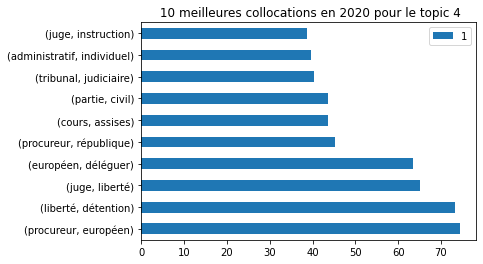

2021
4 Nombre de colonnes = 27  mots : 252
4 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


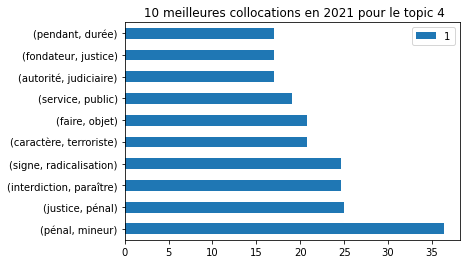

In [580]:
colloc_by_top(law_t, 4)

In [573]:
def colloc_by_year(law, year):
    print(year)
    if year not in law.keys():
        print("Error")
        return("Error, wrong year in input")
    df_year = law[year]
    topics = df_year.Dominant_Topic.sort_values().unique()
    for topic in topics:
        vec = df_year.Text.loc[df_year.Dominant_Topic==topic].values
#        print(vec[0])
    
        vectorizer = CountVectorizer()
        vectorizer.fit(vec)
        X = vectorizer.transform(vec)
        X = X.toarray()
        features = vectorizer.get_feature_names()
        (num_doc, num_f) = X.shape

        print(topic, "Nombre de colonnes =", num_doc," mots : " + str(num_f))
    
        words = [w.lower() for xpo in vec for w in word_tokenize(xpo) if w.lower() != ',']

        for i, word in enumerate(words):
            words[i] = re.sub('\[', "", word)
            words[i] = re.sub('\]', "", word)
    
        bcf = BigramCollocationFinder.from_words(words)
        colloc = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)
        bgm = nltk.collocations.BigramAssocMeasures()
        finder = BigramCollocationFinder.from_words(words)
        scored = bcf.score_ngrams(bgm.likelihood_ratio)
    #likelihood_ratio  #raw_freq
    
#        for i, couple in enumerate(colloc):
#            print(scored[i])
        temp = [dico[tops[0]] for tops in ldamodel.get_topic_terms(int(topic))]
        print(topic, ":", temp)
        
        #plt.show(pd.DataFrame(scored[:10]).plot(kind='barh'))
        plot = pd.DataFrame(scored[:10])
        plot.index = [w[0] for w in scored[:10]]
        plt.show(plot.plot(kind='barh', title=" 10 meilleures collocations en {} pour le topic {}".format(year, int(topic))))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:24: DeprecationWarning: invalid escape sequence \[
<>:25: DeprecationWarning: invalid escape sequence \]
<>:24: DeprecationWarning: invalid escape sequence \[
<>:25: DeprecationWarning: invalid escape sequence \]
<ipython-input-573-356db407fbc6>:24: DeprecationWarning: invalid escape sequence \[
  words[i] = re.sub('\[', "", word)
<ipython-input-573-356db407fbc6>:25: DeprecationWarning: invalid escape sequence \]
  words[i] = re.sub('\]', "", word)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2012
0.0 Nombre de colonnes = 69  mots : 475
0.0 : ['conseil', 'président', 'assemblée', 'organique', 'république', 'modalité', 'uvre', 'préciser', 'membre', 'décision']


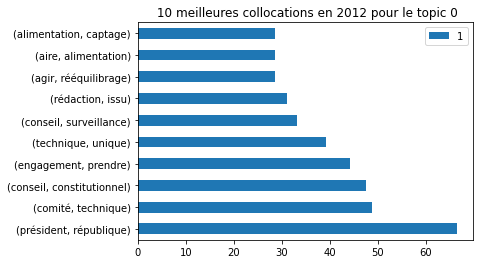

1.0 Nombre de colonnes = 21  mots : 231
1.0 : ['conséquence', 'tirer', 'bénéfice', 'prioritaire', 'commercial', 'cour', 'personne', 'aide', 'devant', 'faire']


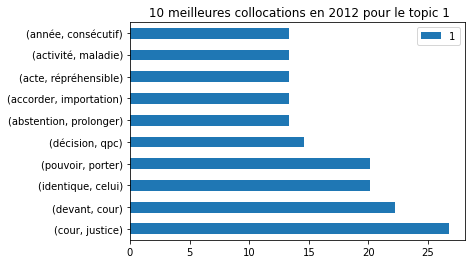

2.0 Nombre de colonnes = 48  mots : 381
2.0 : ['peine', 'personne', 'lorsque', 'pénal', 'infraction', 'pouvoir', 'condamner', 'situation', 'enfant', 'déchet']


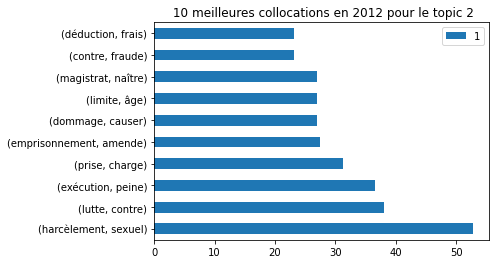

3.0 Nombre de colonnes = 71  mots : 484
3.0 : ['ministre', 'public', 'année', 'rapport', 'présenter', 'urgence', 'ressource', 'militaire', 'charger', 'période']


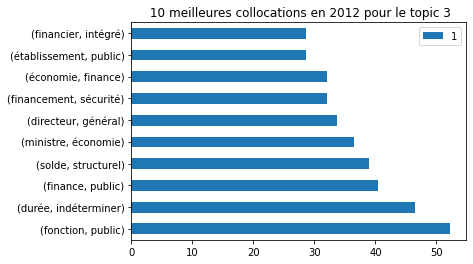

4.0 Nombre de colonnes = 37  mots : 309
4.0 : ['pouvoir', 'judiciaire', 'juge', 'juridiction', 'pénal', 'tribunal', 'décision', 'justice', 'arme', 'alinéa']


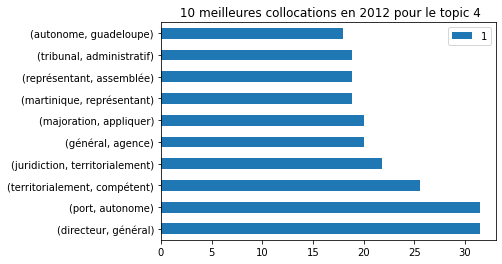

5.0 Nombre de colonnes = 68  mots : 486
5.0 : ['public', 'collectivité', 'établissement', 'territorial', 'enseignement', 'outre-mer', 'local', 'recherche', 'national', 'supérieur']


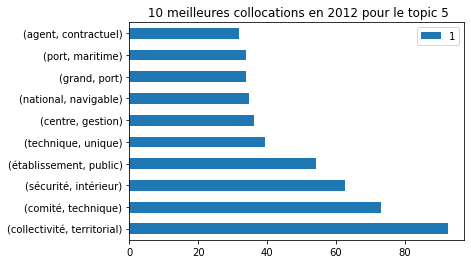

6.0 Nombre de colonnes = 122  mots : 769
6.0 : ['entreprise', 'travail', 'société', 'emploi', 'professionnel', 'salarié', 'social', 'accord', 'organisation', 'activité']


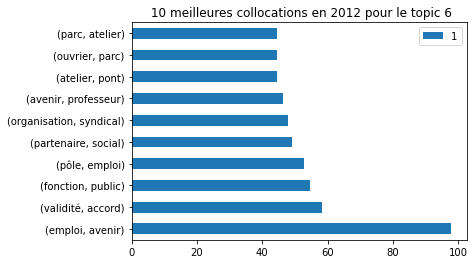

7.0 Nombre de colonnes = 95  mots : 537
7.0 : ['contrat', 'public', 'nouveau', 'mission', 'service', 'règle', 'durée', 'retraite', 'fonction', 'accord']


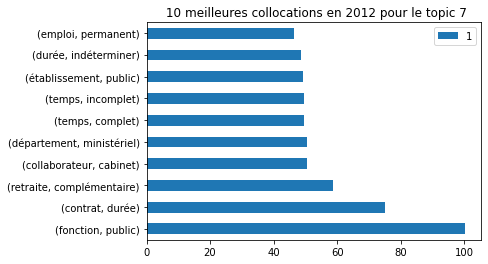

8.0 Nombre de colonnes = 146  mots : 677
8.0 : ['finance', 'public', 'impôt', 'revenu', 'euro', 'fiscal', 'dépense', 'milliard', 'économie', 'taux']


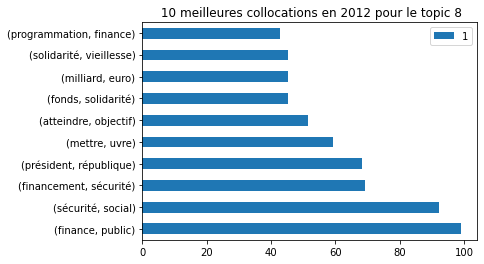

9.0 Nombre de colonnes = 95  mots : 629
9.0 : ['politique', 'développement', 'gouvernement', 'objectif', 'nouveau', 'social', 'économique', 'français', 'renforcer', 'action']


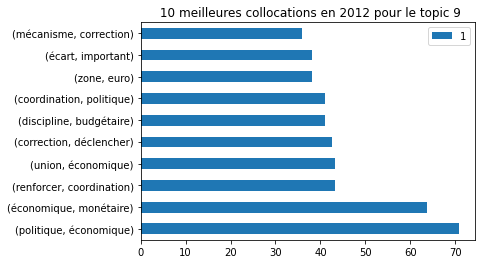

10.0 Nombre de colonnes = 45  mots : 353
10.0 : ['vigueur', 'entrée', 'produit', 'transport', 'réseau', 'service', 'nouveau', 'communication', 'entrer', 'électronique']


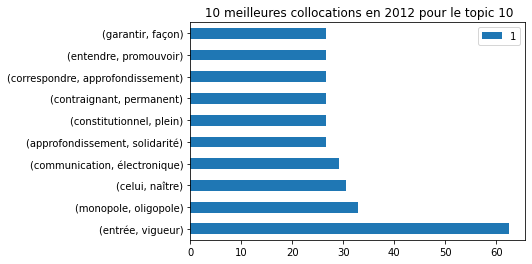

11.0 Nombre de colonnes = 92  mots : 658
11.0 : ['européen', 'France', 'parlement', 'directive', 'union', 'membre', 'français', 'élection', 'électoral', 'conseil']


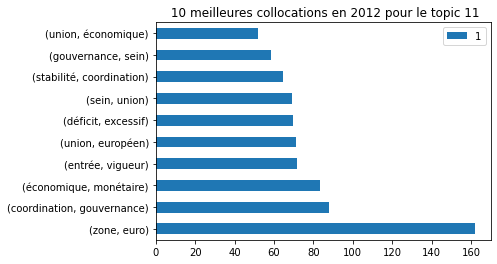

12.0 Nombre de colonnes = 44  mots : 301
12.0 : ['sécurité', 'régime', 'public', 'social', 'donnée', 'santé', 'personnel', 'national', 'technique', 'assurance']


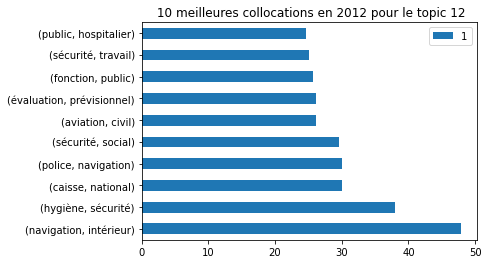

13.0 Nombre de colonnes = 41  mots : 324
13.0 : ['contre', 'international', 'étranger', 'lutte', 'séjour', 'convention', 'renforcer', 'protection', 'sanitaire', 'viser']


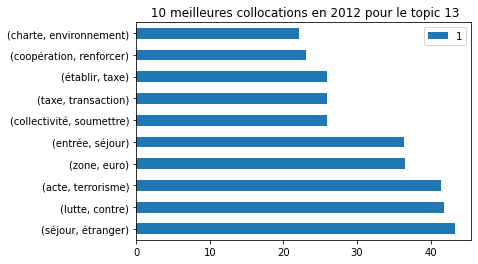

14.0 Nombre de colonnes = 60  mots : 466
14.0 : ['pouvoir', 'autorité', 'contrôle', 'public', 'obligation', 'intérêt', 'date', 'personne', 'opération', 'agent']


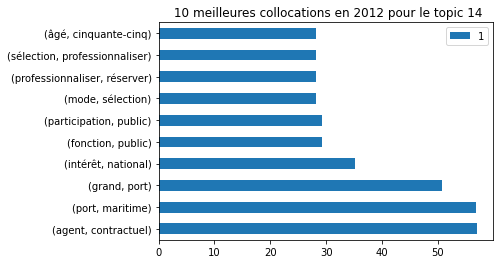

In [574]:
colloc_by_year(law_t, 2012)

# CO-OCCURRENCES

In [357]:
def co_occ_by_year(law, year):
    print(year)
    if year not in law.keys():
        print("Error")
        return("Error, wrong year in input")
    df_year = law[year]
    topics = df_year.Dominant_Topic.sort_values().unique()
    for topic in topics:
        vec = df_year.Text.loc[df_year.Dominant_Topic==topic].values
#        print(vec[0])
        vectorizer = CountVectorizer(max_features=500)
        vectorizer.fit(vec)
        X = vectorizer.transform(vec)
        X = X.toarray()
        features = vectorizer.get_feature_names()
        (num_doc, num_f) = X.shape
    
        cloud_labels = features
        cloud_weights = np.sum(X, axis=0)
        dictionary = dict(zip(cloud_labels, cloud_weights)) 
        sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True) #On dit qu'on trie à partir de la valeur située en 1 (donc le poids)
    
    
        t_freq = np.where(cloud_weights>2)
        index = t_freq[0]
        X_small = X[:,index]
        features_small = np.array(features)[index]
        print(topic, X_small.shape)

        (_,num_f_small) = X_small.shape

        print("Nombre de colonnes =", _," mots : " + str(num_f_small))
    
        co_occ = np.matmul(X_small.transpose(), X_small)

        #features_small = 
        
        for i in range(len(sorted_by_value[0:10])):
            wd, nb = sorted_by_value[i]
            id_mot = np.where(features_small == wd)[0][0]
            scores_coocc = co_occ[id_mot,:]
            dico_co_occ = dict(zip(features_small, scores_coocc))
            mots_coocc = sorted(dico_co_occ.items(), key=lambda kv: kv[1], reverse=True)
            print("[{}] apparaît le plus avec {}".format(wd, mots_coocc[1:6]))
        
        temp = [dico[tops[0]] for tops in ldamodel.get_topic_terms(int(topic))]
        print(topic, ":", temp)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [358]:
co_occ_by_year(law_t, 2012)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2012
0.0 (69, 86)
Nombre de colonnes = 69  mots : 86
[conseil] apparaît le plus avec [('décision', 19), ('public', 12), ('représentant', 12), ('constitutionnel', 9), ('personnel', 9)]
[décision] apparaît le plus avec [('constitutionnel', 21), ('environnement', 21), ('conseil', 19), ('public', 16), ('qpc', 15)]
[président] apparaît le plus avec [('république', 7), ('européen', 6), ('engagement', 4), ('prendre', 4), ('conseil', 3)]
[public] apparaît le plus avec [('décision', 16), ('conseil', 12), ('environnement', 6), ('constitutionnel', 5), ('représentant', 5)]
[constitutionnel] apparaît le plus avec [('constitutionnel', 11), ('conseil', 9), ('qpc', 7), ('environnement', 6), ('participation', 6)]
[représentant] apparaît le plus avec [('assemblée', 16), ('conseil', 12), ('guyane', 12), ('martinique', 12), ('surveillance', 10)]
[français] apparaît le plus avec [('pénal', 6), ('application', 4), ('dès', 4), ('organique', 4), ('devant', 3)]
[pouvoir] apparaît le plus avec [('conseil', 4), 

13.0 (41, 39)
Nombre de colonnes = 41  mots : 39
[contre] apparaît le plus avec [('lutte', 5), ('français', 4), ('fraude', 4), ('fiscal', 3), ('lutter', 3)]
[français] apparaît le plus avec [('commettre', 9), ('étranger', 8), ('acte', 6), ('terrorisme', 6), ('contre', 4)]
[étranger] apparaît le plus avec [('français', 8), ('séjour', 5), ('commettre', 4), ('entrée', 4), ('acte', 3)]
[viser] apparaît le plus avec [('algérien', 3), ('contre', 3), ('fiscal', 3), ('fraude', 3), ('partie', 3)]
[prendre] apparaît le plus avec [('décision', 3), ('environnement', 3), ('renforcer', 3), ('année', 2), ('celui', 2)]
[coopération] apparaît le plus avec [('renforcer', 3), ('année', 2), ('fin', 2), ('financier', 2), ('juridique', 2)]
[entrée] apparaît le plus avec [('séjour', 4), ('étranger', 4), ('compléter', 2), ('fin', 2), ('législatif', 2)]
[lutte] apparaît le plus avec [('lutte', 5), ('fiscal', 3), ('fraude', 3), ('viser', 2), ('mettre', 1)]
[renforcer] apparaît le plus avec [('coopération', 3), 

In [386]:
def co_occ_by_top(law, topic_nb):
    topic = topic_nb
    if topic not in law[2007].Dominant_Topic.unique():
        print("Error")
        return("Error, wrong topic in input")
    for year in law:
        print(year)
        df_year = law[year]
        vec = df_year.Text.loc[df_year.Dominant_Topic==topic].values
#        print(vec[0])
        vectorizer = CountVectorizer(max_features=500)
        vectorizer.fit(vec)
        X = vectorizer.transform(vec)
        X = X.toarray()
        features = vectorizer.get_feature_names()
        (num_doc, num_f) = X.shape
    
        labels = features
        weights = np.sum(X, axis=0)
        dictionary = dict(zip(labels, weights)) 
        sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True) #On dit qu'on trie à partir de la valeur située en 1 (donc le poids)
    
    
        t_freq = np.where(weights>2)
        index = t_freq[0]
        X_small = X[:,index]
        features_small = np.array(features)[index]

        (_,num_f_small) = X_small.shape

        print("Nombre de colonnes =", _," mots : " + str(num_f_small))
        temp = [dico[tops[0]] for tops in ldamodel.get_topic_terms(int(topic))]
        print(topic, ":", temp)
        
        co_occ = np.matmul(X_small.transpose(), X_small)

        tab = []
        tab2 = {}
        
        for i in range(len(sorted_by_value[0:10])):
            wd, nb = sorted_by_value[i]
            id_mot = np.where(features_small == wd)[0][0]
            scores_coocc = co_occ[id_mot,:]
            dico_co_occ = dict(zip(features_small, scores_coocc))
            mots_coocc = sorted(dico_co_occ.items(), key=lambda kv: kv[1], reverse=True)
            print("[{}]: \n {}".format(wd, mots_coocc[1:6]))
            

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [389]:
co_occ_by_top(law_t, 6)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2007
Nombre de colonnes = 113  mots : 155
6 : ['entreprise', 'travail', 'société', 'emploi', 'professionnel', 'salarié', 'social', 'accord', 'organisation', 'activité']
[entreprise]: 
 [('pouvoir', 10), ('salarié', 7), ('travail', 7), ('emploi', 6), ('fiscal', 6)]
[travail]: 
 [('pouvoir', 13), ('achat', 11), ('emploi', 11), ('faveur', 11), ('social', 8)]
[emploi]: 
 [('travail', 11), ('pouvoir', 9), ('faveur', 8), ('prime', 8), ('achat', 7)]
[pouvoir]: 
 [('travail', 13), ('achat', 10), ('entreprise', 10), ('emploi', 9), ('faveur', 8)]
[social]: 
 [('travail', 8), ('entreprise', 6), ('retraite', 6), ('société', 6), ('activité', 5)]
[personnel]: 
 [('enseignant', 5), ('chercheur', 4), ('administration', 3), ('conseil', 3), ('faire', 3)]
[salarié]: 
 [('entreprise', 7), ('bénéficier', 4), ('supplémentaire', 4), ('temps', 4), ('travail', 4)]
[société]: 
 [('public', 9), ('établissement', 8), ('impôt', 7), ('social', 6), ('entreprise', 5)]
[université]: 
 [('formation', 7), ('activité', 5

Nombre de colonnes = 438  mots : 500
6 : ['entreprise', 'travail', 'société', 'emploi', 'professionnel', 'salarié', 'social', 'accord', 'organisation', 'activité']
[entreprise]: 
 [('salarié', 83), ('social', 44), ('formation', 41), ('professionnel', 34), ('emploi', 32)]
[formation]: 
 [('professionnel', 127), ('emploi', 65), ('personnel', 63), ('salarié', 57), ('entreprise', 41)]
[salarié]: 
 [('entreprise', 83), ('formation', 57), ('professionnel', 40), ('emploi', 28), ('employeur', 26)]
[professionnel]: 
 [('formation', 127), ('salarié', 40), ('emploi', 39), ('entreprise', 34), ('celui', 31)]
[social]: 
 [('entreprise', 44), ('économie', 28), ('formation', 26), ('professionnel', 24), ('solidaire', 24)]
[emploi]: 
 [('formation', 65), ('professionnel', 39), ('entreprise', 32), ('salarié', 28), ('celui', 19)]
[société]: 
 [('part', 20), ('social', 16), ('entreprise', 15), ('responsabilité', 14), ('impôt', 13)]
[travail]: 
 [('salarié', 21), ('professionnel', 18), ('formation', 17), ('

6 : ['entreprise', 'travail', 'société', 'emploi', 'professionnel', 'salarié', 'social', 'accord', 'organisation', 'activité']
[entreprise]: 
 [('jour', 6), ('pouvoir', 6), ('activité', 5), ('adapter', 5), ('salarié', 5)]
[pouvoir]: 
 [('entreprise', 6), ('activité', 5), ('part', 4), ('travail', 4), ('adapter', 3)]
[fonds]: 
 [('investissement', 30), ('capital', 24), ('professionnel', 13), ('société', 13), ('commun', 12)]
[travail]: 
 [('service', 7), ('entreprise', 4), ('exercice', 4), ('personne', 4), ('pouvoir', 4)]
[formation]: 
 [('élu', 11), ('local', 6), ('professionnel', 5), ('outil', 4), ('agrément', 3)]
[société]: 
 [('investissement', 11), ('société', 11), ('capital', 10), ('placement', 5), ('risque', 5)]
[élu]: 
 [('élu', 10), ('local', 5), ('professionnel', 4), ('lier', 3), ('organiser', 3)]
[activité]: 
 [('adapter', 5), ('entreprise', 5), ('pouvoir', 5), ('salarié', 4), ('dès', 3)]
[investissement]: 
 [('investissement', 27), ('capital', 22), ('placement', 11), ('risque'

# Créer un réseau avec les co-ooccurences par années

In [495]:
def net_words(law):
    yr = {}
    for year in law:
        df_year = law[year]
        top = {}
        for topic in df_year.Dominant_Topic.sort_values().unique():
            vec = df_year.Text.loc[df_year.Dominant_Topic==topic].values
#            print(vec[0])
            vectorizer = CountVectorizer()
            vectorizer.fit(vec)
            X = vectorizer.transform(vec)
            X = X.toarray()
            features = vectorizer.get_feature_names()
            (num_doc, num_f) = X.shape

            labels = features
            weights = np.sum(X, axis=0)
            dictionary = dict(zip(labels, weights)) 
            sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True) #On dit qu'on trie à partir de la valeur située en 1 (donc le poids)
    
            t_freq = np.where(weights>0)
            index = t_freq[0]
            X_small = X[:,index]
            features_small = np.array(features)[index]
        
            co_occ = np.matmul(X_small.transpose(), X_small)

            tab2 = {}
            wds = {}
            for i in range(len(features_small)):
                wd, nb = sorted_by_value[i]
                id_mot = np.where(features_small == wd)[0][0]
                scores_coocc = co_occ[id_mot,:]
                dico_co_occ = dict(zip(features_small, scores_coocc))
                mots_coocc = sorted(dico_co_occ.items(), key=lambda kv: kv[1], reverse=True)
                
                for mot, nb_mot in mots_coocc:
                    if nb_mot==0:
                        continue;
                    else:
                        tab2[mot] = nb_mot
                    
                wds[wd] = [tab2, nb, int(topic)]           #+'_'+str(topic)
            top[int(topic)] = wds
        yr[year] = top
        print('Done for', year)
    print('Done')
    return(yr)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [496]:
yr = net_words(law_t)
yr.keys()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Done for 2007
Done for 2008
Done for 2009
Done for 2010
Done for 2011
Done for 2012
Done for 2013
Done for 2014
Done for 2015
Done for 2016
Done for 2017
Done for 2018
Done for 2019
Done for 2020
Done for 2021
Done


dict_keys([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [519]:
#yr[2020][2]['personne'][1]
import networkx as nx 

net=nx.Graph()
for top in yr[2015]:
    tops = yr[2015][top]
    for word in tops:
        words = yr[2015][top][word]
        if word not in net:
            net.add_node(word, poids=words[1], topics=str(words[2]))
        if word in net:
            net.nodes[word]['poids']+=words[1]
            net.nodes[word]['topics']+=str(words[2])
            
for top in yr[2015]:
    print(top)
    tops = yr[2015][top]
    for word in tops:
        words = yr[2015][top][word][0]            
        for word2 in words:
            value = words[word2]
            if net.has_edge(word,word2):
                net[word][word2]['connection']+=value
            else:
                net.add_edge(word,word2, connection=value)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [521]:
#nx.number_connected_components(net)
#cc = nx.components.connected_components(net)
#[len(c) for c in sorted(nx.connected_components(net), key=len, reverse=True)]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[4327]

In [524]:
#nx.density(net)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.48381786203905613

In [ ]:
#nx.draw(net)

In [520]:
#nx.write_gexf(net, "./Exports/words_in_corpus.gexf")

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
